In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LIBRARY

In [ ]:
### Our Dataset ###

In [ ]:

! unzip  teeth_dataset.zip -d /content/teeth_dataset/

Archive:  teeth_dataset.zip
   creating: /content/teeth_dataset/teeth_dataset/teeth_dataset/
   creating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/
   creating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_i15.PNG  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_i21.jpg  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_i27.PNG  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_i33.PNG  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_i39.PNG  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_i45.PNG  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_i6.jpg  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_dataset/test/caries/0_wc23.jpg  
  inflating: /content/teeth_dataset/teeth_dataset/teeth_

In [ ]:
#Extract The Images from Zip file
#! unzip  teeth_dataset.zip -d teeth_dataset

In [ ]:
pip install wandb 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=01387d3d2404b2cb8b95c77f04e89189a6394960f977df0afb2191a7d456e673
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import matplotlib.image as mpimg
import pandas as pd
import wandb
import random
import numpy as np
from wandb.keras import WandbCallback


In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 56.9 MB/s eta 0:00:00


# FOLDER TO CSV

In [ ]:
#Load The DataSet
BASE_DIR = '/content/teeth_dataset/teeth_dataset/teeth_dataset' #teethdecay
train_folder = os.path.join(BASE_DIR,'train')
test_folder = os.path.join(BASE_DIR,'test')

# label_ = os.listdir(train_folder) #[caries,no-caries]
# TRAIN TO CSV
df_train = pd.DataFrame()
df_image = []
df_label = []

label_num = 0

for i_label in os.listdir(train_folder):
    for j_image in sorted(os.listdir(os.path.join(train_folder,i_label))): #return full images within the folder
        df_image.append(os.path.join('train',i_label,j_image)) # return path_image
        df_label.append(label_num)
    label_num += 1
df_train['images'] = df_image
df_train['target'] = df_label
#caries = 0, no-caries = 1
df_train.to_csv('./train.csv')

# TEST TO CSV
df_test = pd.DataFrame()
df_image = []
df_label = []

label_num = 0

for i_label in os.listdir(test_folder):
    for j_image in sorted(os.listdir(os.path.join(test_folder,i_label))): #return full images within the folder
        df_image.append(os.path.join('test',i_label,j_image))
        df_label.append(label_num)
    label_num += 1
df_test['images'] = df_image
df_test['target'] = df_label
#caries = 1, no-caries = 0
df_test.to_csv('./test.csv')

In [ ]:
df_train.tail(5),df_test.tail(5)

(                     images  target
 1259  train/caries/wc10.jpg       1
 1260  train/caries/wc16.jpg       1
 1261  train/caries/wc17.jpg       1
 1262   train/caries/wc3.jpg       1
 1263   train/caries/wc9.jpg       1,                    images  target
 427  test/caries/wc30.jpg       1
 428  test/caries/wc31.jpg       1
 429  test/caries/wc33.jpg       1
 430  test/caries/wc34.jpg       1
 431  test/caries/wc38.jpg       1)

# Generator used to Enhance The New Dataset

In [ ]:
"""
import os
import numpy as np
import imgaug.augmenters as iaa
from PIL import Image

def increase_dataset_size(folder_path, target_size=1000):
    # Define the augmentations
    
    seq = iaa.Sequential([
        iaa.Flipud(0.5),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-90, 90)),
    #    iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
        iaa.Multiply((0.8, 1.2)),
        iaa.Sequential([
            iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
        ]),
    #    iaa.GaussianBlur(sigma=(0, 2.0)),
        iaa.Dropout(p=(0, 0.1)),
        iaa.Add((-40, 40), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.5),
        iaa.Crop(px=(0, 16)), # randomly crop images
        iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),
        iaa.PerspectiveTransform(scale=(0.01, 0.1)),
        iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200)),
        iaa.PiecewiseAffine(scale=(0.01, 0.05)),
        iaa.Grayscale(alpha=(0.0, 1.0))
    ])

    images = []
    for file in os.listdir(folder_path):
        if file.endswith(".jpg") or file.endswith(".png"):
            file_path = os.path.join(folder_path, file)
            image = Image.open(file_path)
            images.append(np.array(image))
    data = np.array(images)

    current_size = data.shape[0]
    factor = target_size // current_size + 1
    augmented_data = data
    for i in range(factor):
        augmented_data = np.concatenate((augmented_data, seq(images=data)), axis=0)
    return augmented_data


def save_augmented_images(data, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for i, img in enumerate(data):
        file_path = os.path.join(folder_path, 'img_' + str(i) + '.jpg')
        image = Image.fromarray(img)
        image.save(file_path)


"""
"""
input_folder1 = '/content/train-no-caries/train-no/'  #input folder contains dataset for generate
output_folder1 = '/content/Generated/train-no-caries-old7/' #output folder to put the new enhanced dataset

augmented_data = increase_dataset_size(input_folder1, target_size=500)
save_augmented_images(augmented_data, output_folder1)

"""

# VISUALIZE DATA

In [ ]:
print('Number of train images:',len(df_train))
print('Number of test images:',len(df_test))

Number of train images: 1264
Number of test images: 432


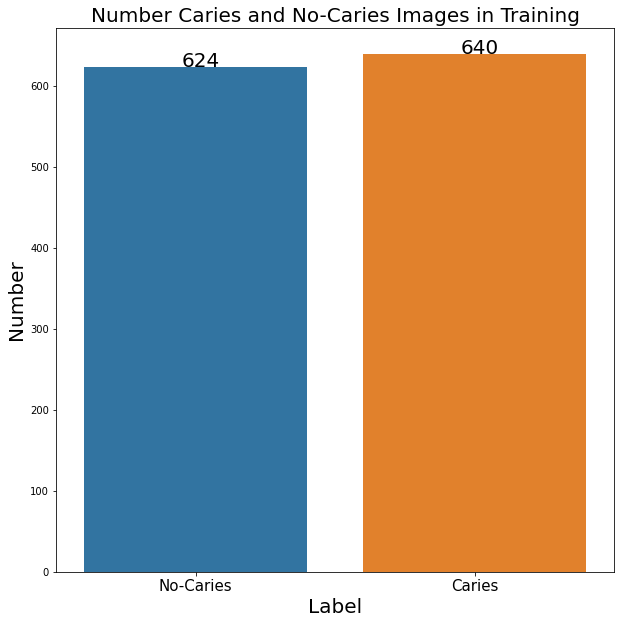

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x = 'target', data = df_train)
ax.set_title('Number Caries and No-Caries Images in Training', size=20)
ax.set_xlabel("Label",fontsize=20)
ax.set_ylabel("Number",fontsize=20)
ax.set_xticklabels(['No-Caries', 'Caries'],fontsize=15)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2),fontsize=20)

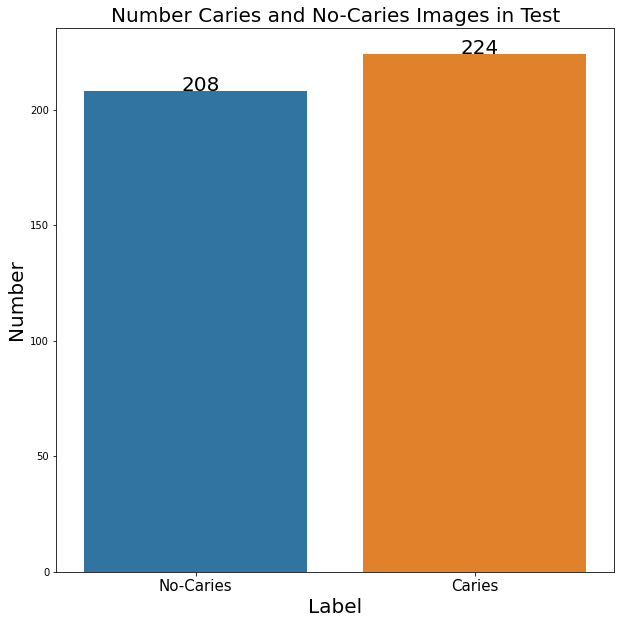

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x = 'target', data = df_test)
ax.set_title('Number Caries and No-Caries Images in Test', size=20)
ax.set_xlabel("Label",fontsize=20)
ax.set_ylabel("Number",fontsize=20)
ax.set_xticklabels(['No-Caries', 'Caries'],fontsize=15)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2),fontsize=20)

Text(0.5, 1.0, '% Carries and No-Caries In Train')

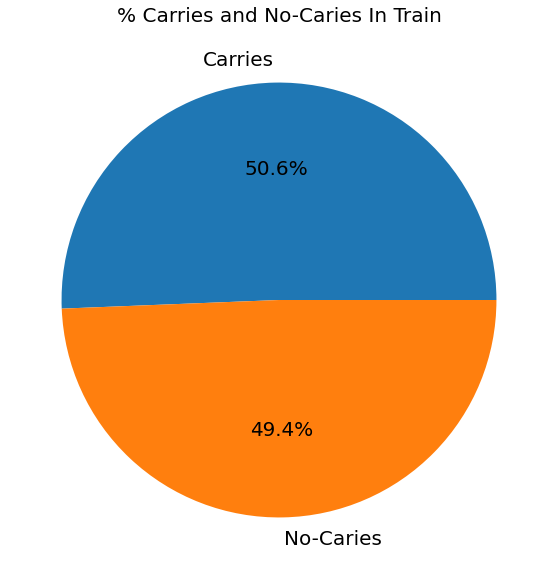

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
bar.patch.set_facecolor('white')
plt.pie(df_train['target'].value_counts(), 
        labels = ['Carries','No-Caries'], 
        autopct="%.1f%%",textprops={'fontsize':20})
plt.title('% Carries and No-Caries In Train', size=20)

Text(0.5, 1.0, '% Carries and No-Caries In Test')

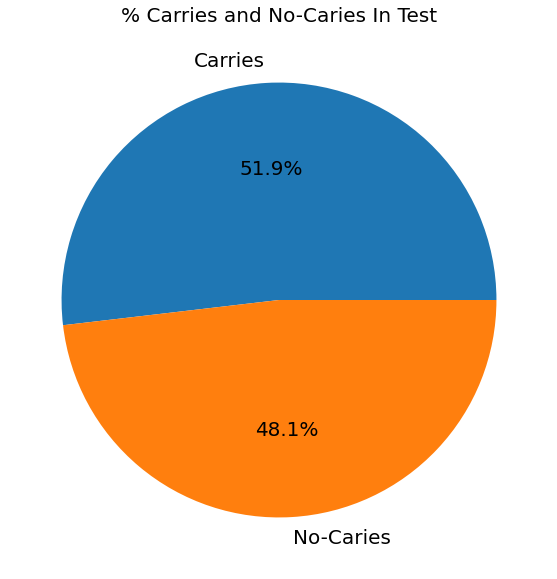

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
bar.patch.set_facecolor('white')
plt.pie(df_test['target'].value_counts(), 
        labels = ['Carries','No-Caries'], 
        autopct="%.1f%%",textprops={'fontsize':20})
plt.title('% Carries and No-Caries In Test', size=20)

In [ ]:
#Print Shape of dataset to choose rescale
#for i in os.listdir(os.path.join(BASE_DIR,'train','caries')):
#    im = cv2.imread(os.path.join(BASE_DIR,'train','caries',i)) #H,W,C
#  # print(im.shape)
#for i in os.listdir(os.path.join(BASE_DIR,'train','caries')):
#    im = cv2.imread(os.path.join(BASE_DIR,'train','caries',i)) #H,W,C
#for i in os.listdir(os.path.join(BASE_DIR,'train','caries')):
#    im = cv2.imread(os.path.join(BASE_DIR,'train','caries',i)) #H,W,C
#for i in os.listdir(os.path.join(BASE_DIR,'train','caries')):
#    im = cv2.imread(os.path.join(BASE_DIR,'train','caries',i)) #H,W,C
print('Choose 224x224 rescale is best choice')

Choose 224x224 rescale is best choice


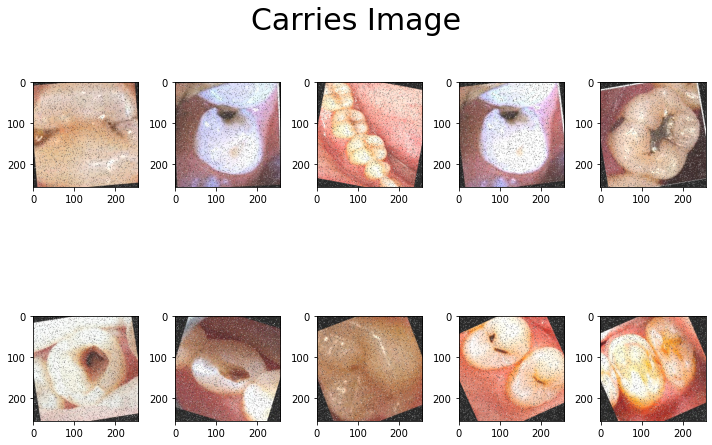

In [ ]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
f.suptitle('Carries Image',x=0.5,y=0.8,fontsize=30,verticalalignment='bottom')
k = 0
for i in range(2):
    for j in range(5):
        img = cv2.imread(os.path.join('/content/teeth_dataset/teeth_dataset/teeth_dataset' ,'train','caries',random.choice(os.listdir(os.path.join('/content/teeth_dataset/teeth_dataset/teeth_dataset' ,'train','caries')))))
        im_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        k = k + 1
    plt.tight_layout()

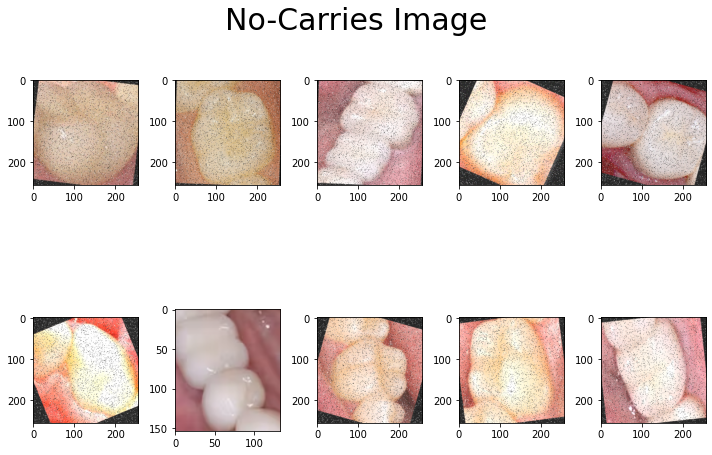

In [ ]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
f.suptitle('No-Carries Image',x=0.5,y=0.8,fontsize=30,verticalalignment='bottom')
k = 0
for i in range(2):
    for j in range(5):
        img = cv2.imread(os.path.join('/content/teeth_dataset/teeth_dataset/teeth_dataset' ,'train','no-caries',random.choice(os.listdir(os.path.join('/content/teeth_dataset/teeth_dataset/teeth_dataset' ,'train','no-caries')))))
        im_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        k = k + 1
    plt.tight_layout()

#Validate Generator

In [ ]:
# Set up Generator
train_generator = ImageDataGenerator( 
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
val_generator = ImageDataGenerator(rescale=1./255.)

In [ ]:
# Set up dataload
train_datagen = train_generator.flow_from_directory(
    train_folder, 
    batch_size=10,
    target_size=(224, 224)
)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224)
)

Found 1264 images belonging to 2 classes.
Found 432 images belonging to 2 classes.


Found 1264 images belonging to 2 classes.


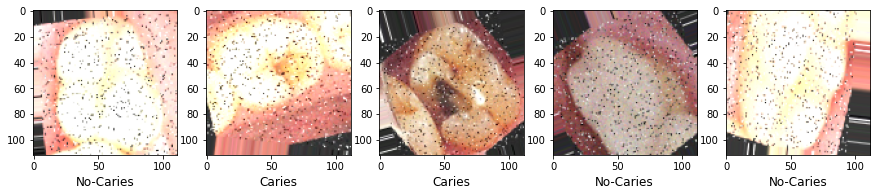

In [ ]:
# Images After DATAGENERATOR
# Loads image in from the set image path
pic = train_generator.flow_from_directory(
   '/content/teeth_dataset/teeth_dataset/teeth_dataset/train' , 
    batch_size=1,
    target_size=(112, 112))
f,ax = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(5):
    img, label = pic.next()
    ax[i].imshow(img[0])
    ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

In [ ]:
!pip install google.colab
from google.colab.patches import cv2_imshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.0 MB/s eta 0:00:00


# Train By VGG19 Model



In [ ]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3),weights=None,include_top=False,classes=2)

In [ ]:
modelVGG19 = Sequential()
modelVGG19.add(base_model)
modelVGG19.add(Flatten())
modelVGG19.add(Dense(512, activation="relu"))
modelVGG19.add(Dropout(0.3))
modelVGG19.add(Dense(256, activation="relu"))
modelVGG19.add(Dropout(0.6))
modelVGG19.add(Dense(2, activation="softmax"))
modelVGG19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                

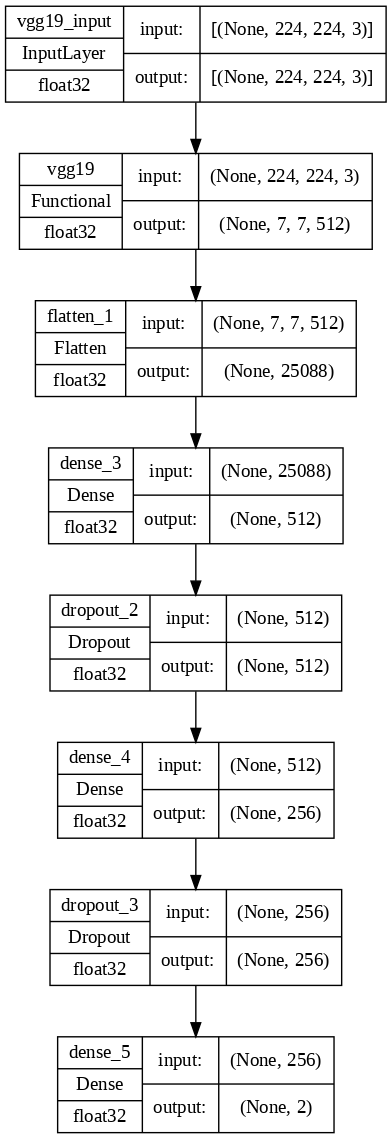

In [ ]:
tf.keras.utils.plot_model(modelVGG19, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB",  dpi = 100 ,to_file='VGG19.png')

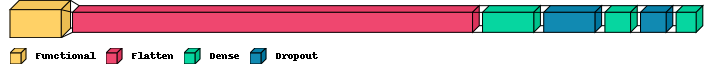

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelVGG19, legend=True, font=font,to_file='output_VGG19.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam = RMSprop = SGD
modelVGG19.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/VGG19_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_VGG19.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelVGG19.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4937
Epoch 1: saving model to best_model_VGG19.h5


127/127 [==============================] - 49s 365ms/step - loss: 0.6941 - accuracy: 0.4937 - val_loss: 0.6933 - val_accuracy: 0.4815
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.4913
Epoch 2: saving model to best_model_VGG19.h5


127/127 [==============================] - 44s 347ms/step - loss: 0.6969 - accuracy: 0.4913 - val_loss: 0.6930 - val_accuracy: 0.5185
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.5024
Epoch 3: saving model to best_model_VGG19.h5


127/127 [==============================] - 43s 335ms/step - loss: 0.7013 - accuracy: 0.5024 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5047
Epoch 4: saving model to best_model_VGG19.h5


127/127 [==============================] - 41s 319ms/step - loss: 0.6934 - accuracy: 0.5047 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5040
Epoch 5: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 231ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5150
Epoch 6: saving model to best_model_VGG19.h5


127/127 [==============================] - 31s 242ms/step - loss: 0.6934 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5134
Epoch 7: saving model to best_model_VGG19.h5


127/127 [==============================] - 32s 249ms/step - loss: 0.7040 - accuracy: 0.5134 - val_loss: 0.6713 - val_accuracy: 0.7222
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.7484
Epoch 8: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 238ms/step - loss: 0.6044 - accuracy: 0.7484 - val_loss: 0.6470 - val_accuracy: 0.5741
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8315
Epoch 9: saving model to best_model_VGG19.h5


127/127 [==============================] - 31s 240ms/step - loss: 0.4451 - accuracy: 0.8315 - val_loss: 0.4177 - val_accuracy: 0.8565
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.9074
Epoch 10: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 238ms/step - loss: 0.2837 - accuracy: 0.9074 - val_loss: 0.3092 - val_accuracy: 0.9167
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9177
Epoch 11: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 238ms/step - loss: 0.2500 - accuracy: 0.9177 - val_loss: 0.4232 - val_accuracy: 0.9259
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9304
Epoch 12: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 238ms/step - loss: 0.1996 - accuracy: 0.9304 - val_loss: 0.5098 - val_accuracy: 0.9144
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9446
Epoch 13: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 236ms/step - loss: 0.1818 - accuracy: 0.9446 - val_loss: 0.4810 - val_accuracy: 0.9491
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9438
Epoch 14: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 236ms/step - loss: 0.1891 - accuracy: 0.9438 - val_loss: 0.2419 - val_accuracy: 0.9236
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9375
Epoch 15: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 236ms/step - loss: 0.2091 - accuracy: 0.9375 - val_loss: 0.2076 - val_accuracy: 0.9560
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9415
Epoch 16: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 238ms/step - loss: 0.1912 - accuracy: 0.9415 - val_loss: 0.1566 - val_accuracy: 0.9468
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9486
Epoch 17: saving model to best_model_VGG19.h5


127/127 [==============================] - 31s 239ms/step - loss: 0.1571 - accuracy: 0.9486 - val_loss: 0.3466 - val_accuracy: 0.9491
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9589
Epoch 18: saving model to best_model_VGG19.h5


127/127 [==============================] - 32s 249ms/step - loss: 0.1586 - accuracy: 0.9589 - val_loss: 0.1915 - val_accuracy: 0.9329
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9612
Epoch 19: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 236ms/step - loss: 0.1416 - accuracy: 0.9612 - val_loss: 0.1827 - val_accuracy: 0.9329
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9573
Epoch 20: saving model to best_model_VGG19.h5


127/127 [==============================] - 30s 239ms/step - loss: 0.1377 - accuracy: 0.9573 - val_loss: 0.1665 - val_accuracy: 0.9421


# Plot Accuracy and Loss VGG19

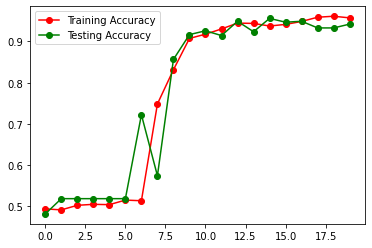

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

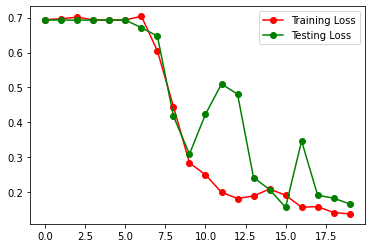

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelVGG19.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 2s 1s/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.98      0.91      0.94       224
   no-caries       0.91      0.98      0.94       208

   micro avg       0.94      0.94      0.94       432
   macro avg       0.94      0.94      0.94       432
weighted avg       0.95      0.94      0.94       432
 samples avg       0.94      0.94      0.94       432



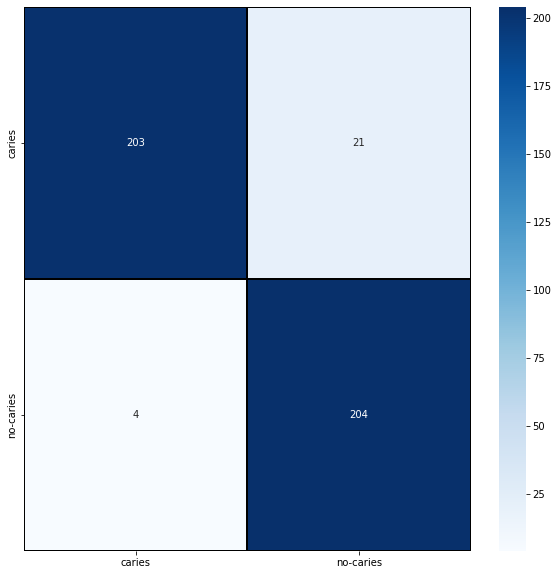

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.9435096153846154


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([0.98067633, 0.90666667])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.90625   , 0.98076923])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.94199536, 0.94226328])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

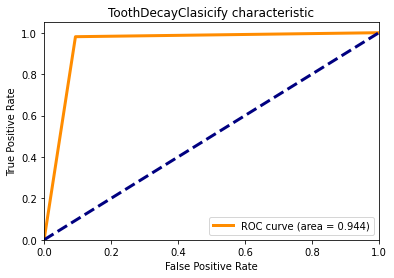

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-73-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


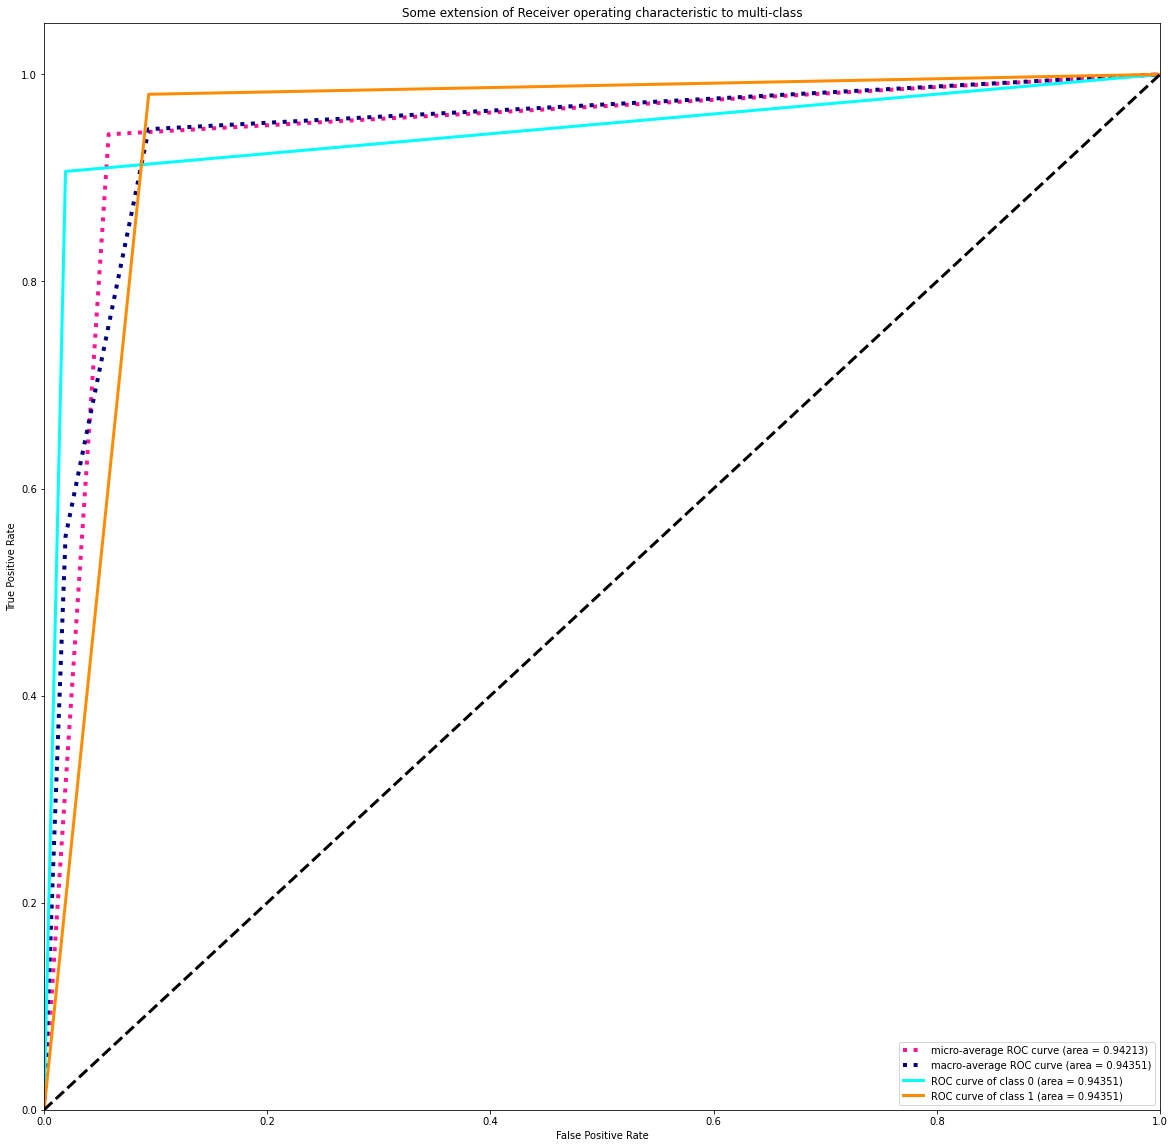

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By VGG16 Model

In [ ]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3),weights=None,include_top=False,classes=2)

In [ ]:
modelVGG16 = Sequential()
modelVGG16.add(base_model)
modelVGG16.add(Flatten())
modelVGG16.add(Dense(512, activation="relu"))
modelVGG16.add(Dropout(0.3))
modelVGG16.add(Dense(256, activation="relu"))
modelVGG16.add(Dense(2, activation="softmax"))
modelVGG16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 2)                 514       
                                                                 
Total params: 27,692,098
Trainable params: 27,692,098


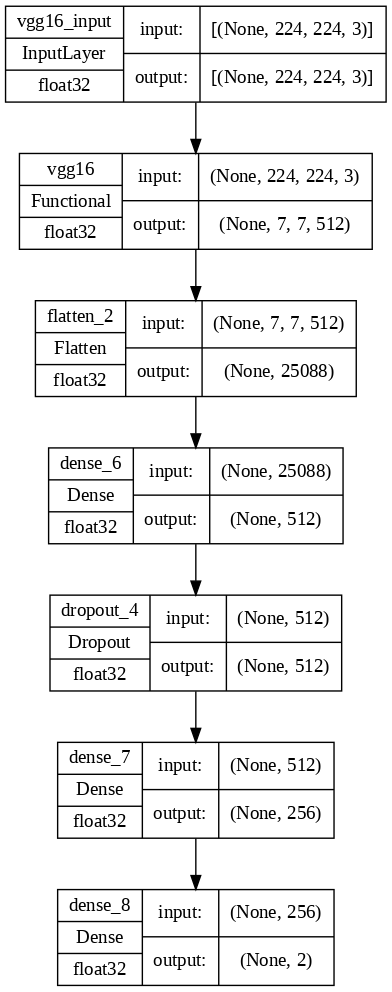

In [ ]:
tf.keras.utils.plot_model(modelVGG16, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB",  dpi = 100 ,to_file='VGG16.png')

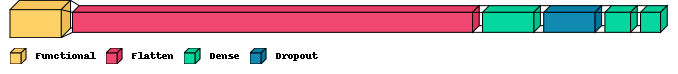

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelVGG16, legend=True, font=font,to_file='output_VGG16.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam = RMSprop = SGD
modelVGG16.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/VGG16_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelVGG16.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.4913
Epoch 1: saving model to best_model.h5


127/127 [==============================] - 30s 222ms/step - loss: 0.7049 - accuracy: 0.4913 - val_loss: 0.6939 - val_accuracy: 0.4815
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.4984
Epoch 2: saving model to best_model.h5


127/127 [==============================] - 27s 211ms/step - loss: 0.6970 - accuracy: 0.4984 - val_loss: 0.6899 - val_accuracy: 0.5185
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.6456
Epoch 3: saving model to best_model.h5


127/127 [==============================] - 27s 213ms/step - loss: 0.6561 - accuracy: 0.6456 - val_loss: 0.4052 - val_accuracy: 0.8611
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8521
Epoch 4: saving model to best_model.h5


127/127 [==============================] - 27s 214ms/step - loss: 0.3995 - accuracy: 0.8521 - val_loss: 0.2862 - val_accuracy: 0.9028
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9193
Epoch 5: saving model to best_model.h5


127/127 [==============================] - 28s 216ms/step - loss: 0.2653 - accuracy: 0.9193 - val_loss: 0.3297 - val_accuracy: 0.8981
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9161
Epoch 6: saving model to best_model.h5


127/127 [==============================] - 27s 214ms/step - loss: 0.2428 - accuracy: 0.9161 - val_loss: 0.1796 - val_accuracy: 0.9306
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9359
Epoch 7: saving model to best_model.h5


127/127 [==============================] - 27s 215ms/step - loss: 0.2144 - accuracy: 0.9359 - val_loss: 0.2149 - val_accuracy: 0.9329
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9422
Epoch 8: saving model to best_model.h5


127/127 [==============================] - 27s 213ms/step - loss: 0.2139 - accuracy: 0.9422 - val_loss: 0.3196 - val_accuracy: 0.8241
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9478
Epoch 9: saving model to best_model.h5


127/127 [==============================] - 27s 210ms/step - loss: 0.1588 - accuracy: 0.9478 - val_loss: 0.1975 - val_accuracy: 0.9398
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9557
Epoch 10: saving model to best_model.h5


127/127 [==============================] - 27s 210ms/step - loss: 0.1313 - accuracy: 0.9557 - val_loss: 0.2070 - val_accuracy: 0.9560
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9525
Epoch 11: saving model to best_model.h5


127/127 [==============================] - 29s 230ms/step - loss: 0.1688 - accuracy: 0.9525 - val_loss: 0.1554 - val_accuracy: 0.9491
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9525
Epoch 12: saving model to best_model.h5


127/127 [==============================] - 27s 212ms/step - loss: 0.1337 - accuracy: 0.9525 - val_loss: 0.3625 - val_accuracy: 0.9398
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9652
Epoch 13: saving model to best_model.h5


127/127 [==============================] - 27s 210ms/step - loss: 0.1284 - accuracy: 0.9652 - val_loss: 0.1727 - val_accuracy: 0.9583
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9699
Epoch 14: saving model to best_model.h5


127/127 [==============================] - 27s 209ms/step - loss: 0.0938 - accuracy: 0.9699 - val_loss: 0.2832 - val_accuracy: 0.8981
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9691
Epoch 15: saving model to best_model.h5


127/127 [==============================] - 27s 211ms/step - loss: 0.1005 - accuracy: 0.9691 - val_loss: 0.2760 - val_accuracy: 0.9491
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9636
Epoch 16: saving model to best_model.h5


127/127 [==============================] - 27s 212ms/step - loss: 0.1110 - accuracy: 0.9636 - val_loss: 0.2510 - val_accuracy: 0.9421
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9707
Epoch 17: saving model to best_model.h5


127/127 [==============================] - 27s 212ms/step - loss: 0.0997 - accuracy: 0.9707 - val_loss: 0.2896 - val_accuracy: 0.9352
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9763
Epoch 18: saving model to best_model.h5


127/127 [==============================] - 27s 213ms/step - loss: 0.0950 - accuracy: 0.9763 - val_loss: 0.3867 - val_accuracy: 0.9514
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9763
Epoch 19: saving model to best_model.h5


127/127 [==============================] - 27s 212ms/step - loss: 0.1240 - accuracy: 0.9763 - val_loss: 0.4415 - val_accuracy: 0.9444
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9723
Epoch 20: saving model to best_model.h5


127/127 [==============================] - 27s 214ms/step - loss: 0.1001 - accuracy: 0.9723 - val_loss: 0.2244 - val_accuracy: 0.9583


# Plot Accuracy and Loss VGG16

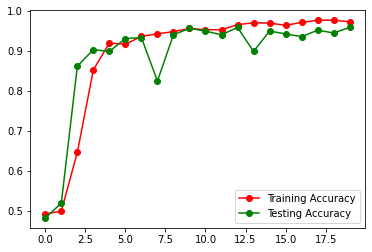

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

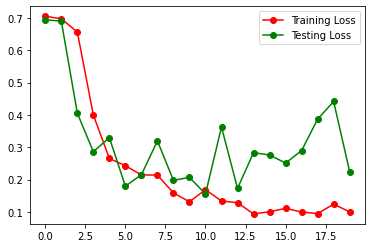

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelVGG16.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 2s 1s/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       1.00      0.92      0.96       224
   no-caries       0.92      1.00      0.96       208

   micro avg       0.96      0.96      0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432
 samples avg       0.96      0.96      0.96       432



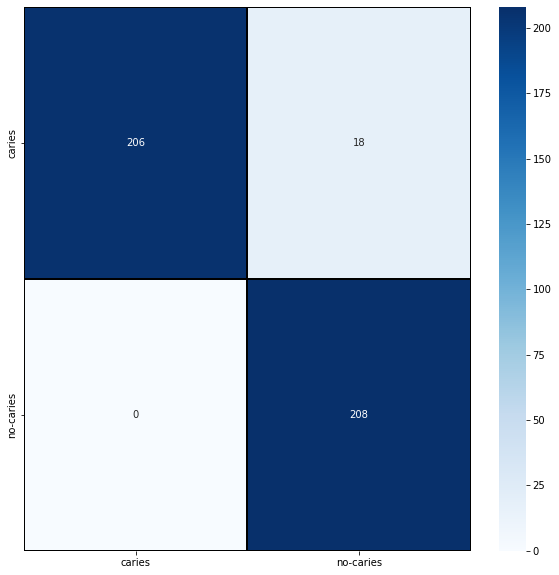

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.9598214285714286


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([1.        , 0.92035398])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.91964286, 1.        ])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.95813953, 0.95852535])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

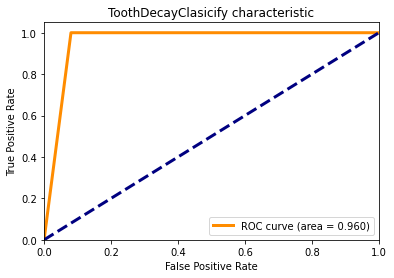

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-97-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


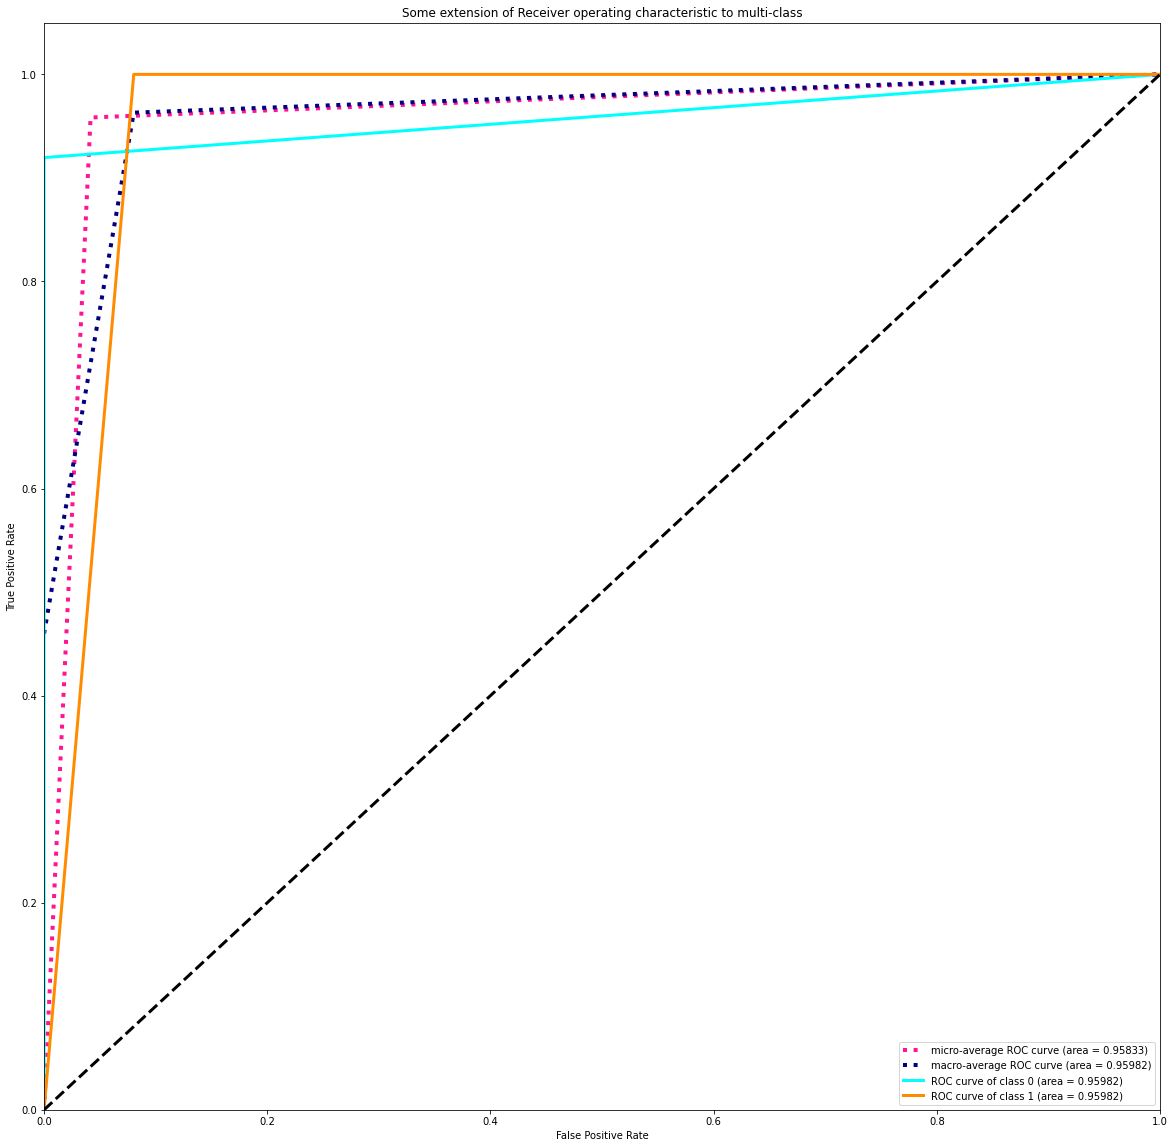

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install google.colab
from google.colab.patches import cv2_imshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Train By ResNet50 Model


In [ ]:
# using Pre-trained model " ResNet50 "

In [ ]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),weights=None,include_top=False,classes=2)

In [ ]:
modelResNet50 = Sequential()
modelResNet50.add(base_model)
modelResNet50.add(Flatten())
modelResNet50.add(Dense(256, activation="relu"))
modelResNet50.add(Dropout(0.3))
modelResNet50.add(Dense(2, activation="softmax"))
modelResNet50.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 2)                 514       
                                                                 
Total params: 49,278,594
Trainable params: 49,225,474
Non-trainable params: 53,120
_________________________________________________________________


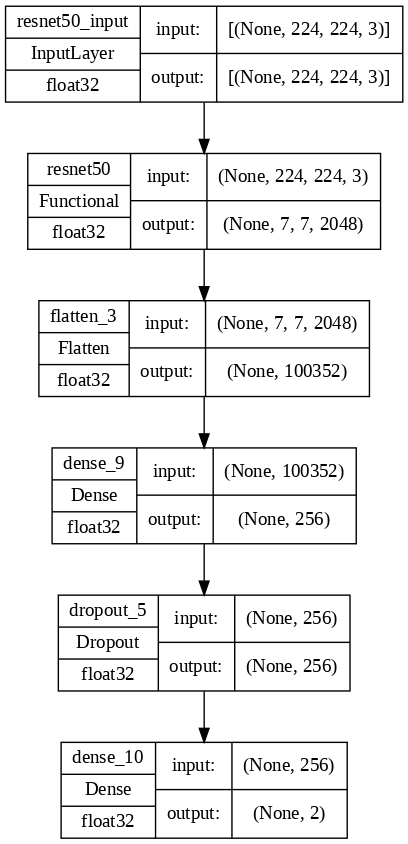

In [ ]:
tf.keras.utils.plot_model(modelResNet50, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", dpi = 100 ,to_file='ResNet50.png')

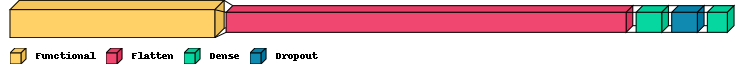

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelResNet50, legend=True, font=font,to_file='output_ResNet50.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam 
modelResNet50.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/ResNet50_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelResNet50.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 15.5097 - accuracy: 0.4992
Epoch 1: saving model to best_model.h5


127/127 [==============================] - 51s 357ms/step - loss: 15.5097 - accuracy: 0.4992 - val_loss: 0.7058 - val_accuracy: 0.4815
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.7523 - accuracy: 0.5063
Epoch 2: saving model to best_model.h5


127/127 [==============================] - 28s 222ms/step - loss: 0.7523 - accuracy: 0.5063 - val_loss: 0.7047 - val_accuracy: 0.4815
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5166
Epoch 3: saving model to best_model.h5


127/127 [==============================] - 27s 213ms/step - loss: 0.6946 - accuracy: 0.5166 - val_loss: 0.6926 - val_accuracy: 0.5185
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.4984
Epoch 4: saving model to best_model.h5


127/127 [==============================] - 27s 209ms/step - loss: 0.6921 - accuracy: 0.4984 - val_loss: 0.6936 - val_accuracy: 0.5023
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4968
Epoch 5: saving model to best_model.h5


127/127 [==============================] - 27s 212ms/step - loss: 0.6938 - accuracy: 0.4968 - val_loss: 0.6924 - val_accuracy: 0.5162
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4953
Epoch 6: saving model to best_model.h5


127/127 [==============================] - 27s 209ms/step - loss: 0.6941 - accuracy: 0.4953 - val_loss: 0.6928 - val_accuracy: 0.5162
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4984
Epoch 7: saving model to best_model.h5


127/127 [==============================] - 27s 209ms/step - loss: 0.6934 - accuracy: 0.4984 - val_loss: 0.6927 - val_accuracy: 0.5162
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5142
Epoch 8: saving model to best_model.h5


127/127 [==============================] - 29s 228ms/step - loss: 0.6933 - accuracy: 0.5142 - val_loss: 0.6935 - val_accuracy: 0.5069
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5008
Epoch 9: saving model to best_model.h5


127/127 [==============================] - 26s 207ms/step - loss: 0.6935 - accuracy: 0.5008 - val_loss: 0.6926 - val_accuracy: 0.5185
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5047
Epoch 10: saving model to best_model.h5


127/127 [==============================] - 26s 207ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5047
Epoch 11: saving model to best_model.h5


127/127 [==============================] - 26s 206ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5071
Epoch 12: saving model to best_model.h5


127/127 [==============================] - 27s 209ms/step - loss: 0.6937 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5055
Epoch 13: saving model to best_model.h5


127/127 [==============================] - 27s 214ms/step - loss: 0.6933 - accuracy: 0.5055 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5063
Epoch 14: saving model to best_model.h5


127/127 [==============================] - 26s 206ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 15: saving model to best_model.h5


127/127 [==============================] - 26s 205ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5063
Epoch 16: saving model to best_model.h5


127/127 [==============================] - 27s 208ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5063
Epoch 17: saving model to best_model.h5


127/127 [==============================] - 27s 208ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5063
Epoch 18: saving model to best_model.h5


127/127 [==============================] - 26s 204ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5063
Epoch 19: saving model to best_model.h5


127/127 [==============================] - 27s 209ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 20: saving model to best_model.h5


127/127 [==============================] - 26s 207ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185


# Plot Accuracy and Loss ResNet50

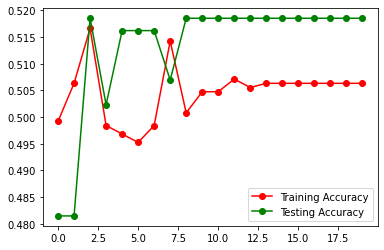

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

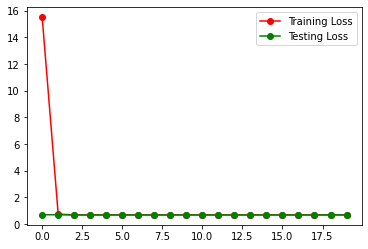

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelResNet50.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 2s 667ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.52      1.00      0.68       224
   no-caries       0.00      0.00      0.00       208

   micro avg       0.52      0.52      0.52       432
   macro avg       0.26      0.50      0.34       432
weighted avg       0.27      0.52      0.35       432
 samples avg       0.52      0.52      0.52       432



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


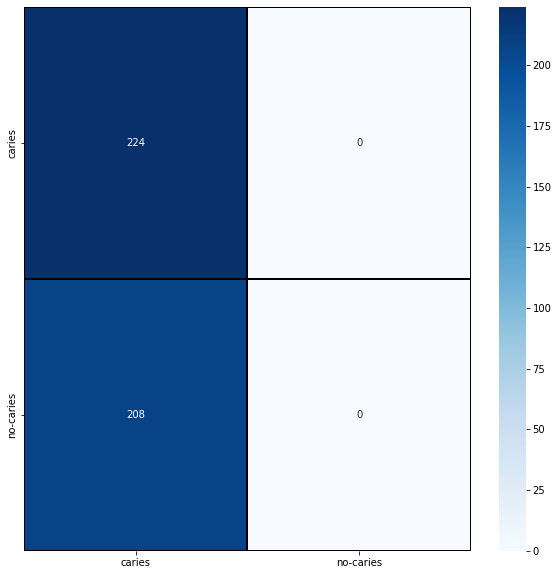

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.5


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.51851852, 0.        ])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([1., 0.])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.68292683, 0.        ])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

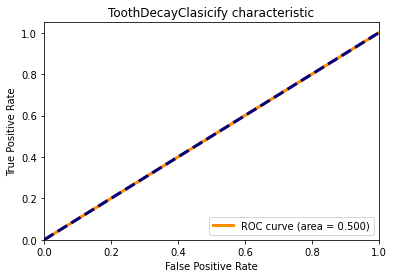

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-123-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


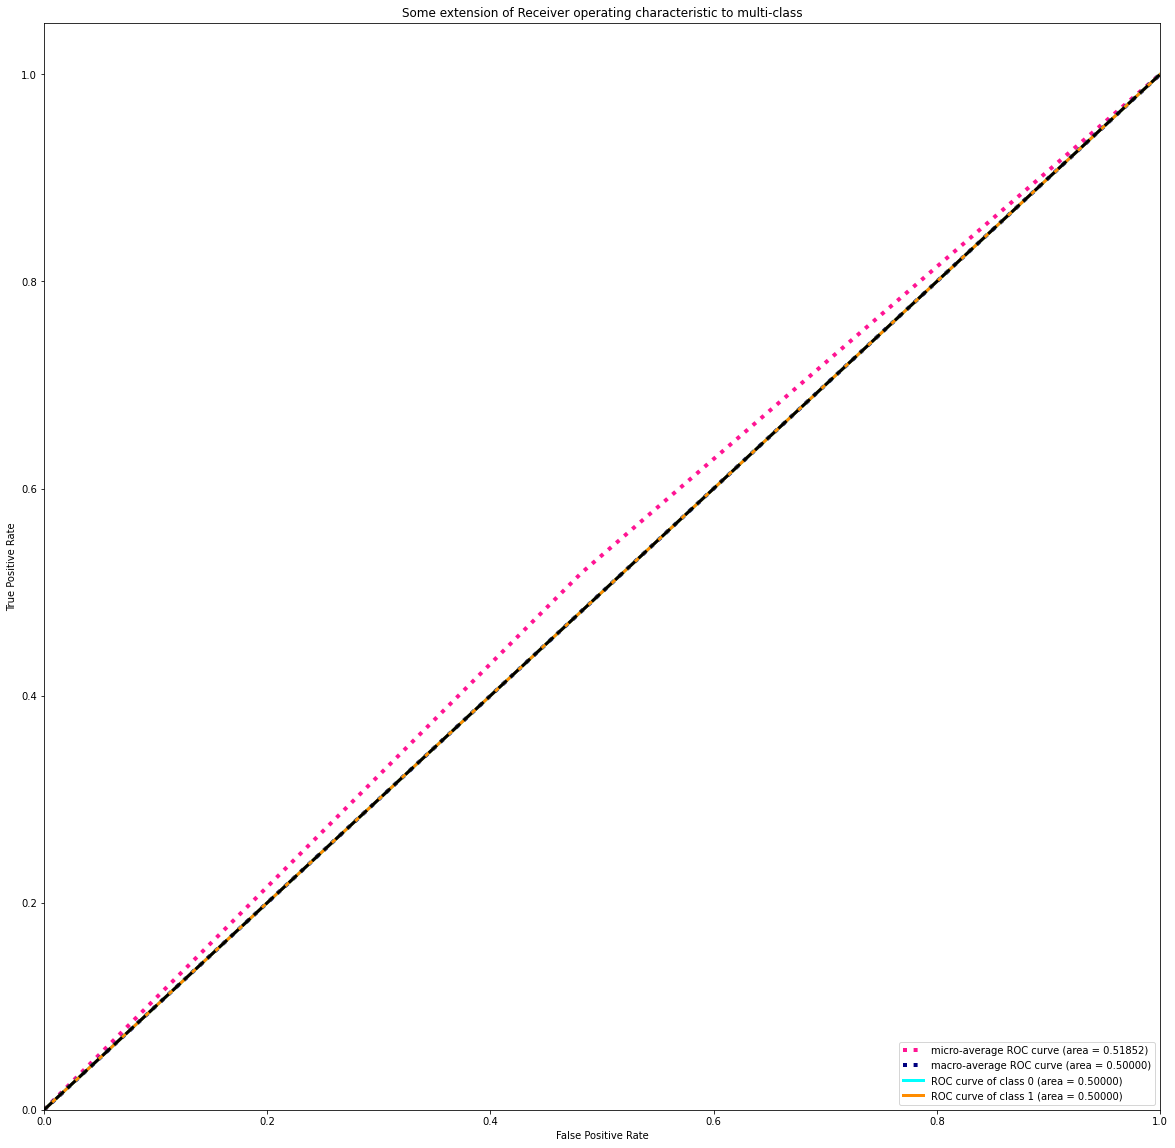

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By DenseNet121 Model


In [ ]:
# using Pre-trained model " DenseNet121 "

In [ ]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),weights=None,include_top=False,classes=2)

In [ ]:
modelDenseNet121 = Sequential()
modelDenseNet121.add(base_model)
modelDenseNet121.add(Flatten())
modelDenseNet121.add(Dense(512, activation="relu"))
modelDenseNet121.add(Dropout(0.3))
modelDenseNet121.add(Dense(256, activation="relu"))
modelDenseNet121.add(Dropout(0.6))
modelDenseNet121.add(Dense(2, activation="softmax"))
modelDenseNet121.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               25690624  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                

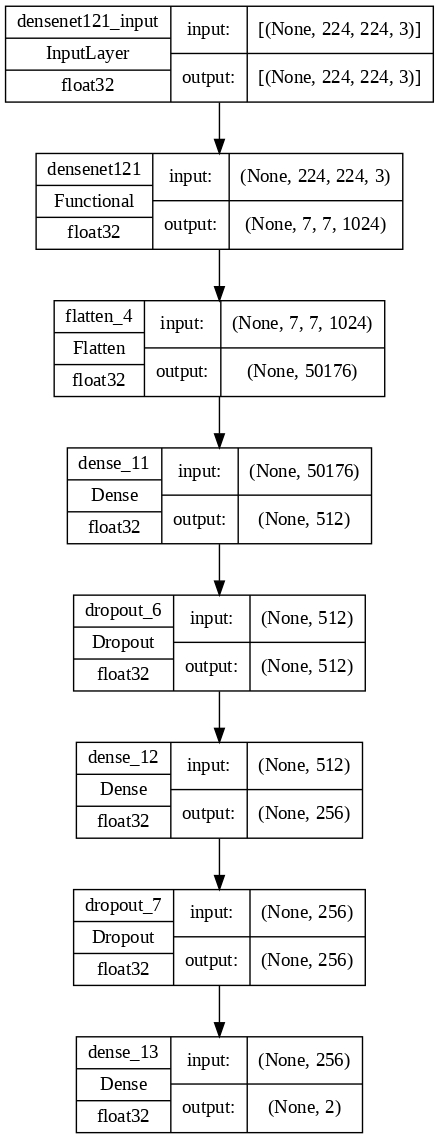

In [ ]:
tf.keras.utils.plot_model(modelDenseNet121, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", dpi = 100 ,to_file='DenseNet121.png')

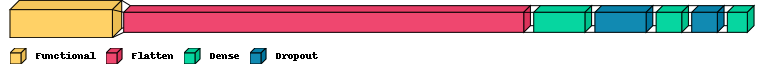

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelDenseNet121, legend=True, font=font,to_file='output_DenseNet121.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam 
modelDenseNet121.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/DenseNet121_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelDenseNet121.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 1.8926 - accuracy: 0.6155
Epoch 1: saving model to best_model.h5


127/127 [==============================] - 70s 285ms/step - loss: 1.8926 - accuracy: 0.6155 - val_loss: 0.9799 - val_accuracy: 0.4815
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.8168 - accuracy: 0.7231
Epoch 2: saving model to best_model.h5


127/127 [==============================] - 26s 207ms/step - loss: 0.8168 - accuracy: 0.7231 - val_loss: 3.1580 - val_accuracy: 0.4815
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.8109
Epoch 3: saving model to best_model.h5


127/127 [==============================] - 28s 219ms/step - loss: 0.5391 - accuracy: 0.8109 - val_loss: 2.1647 - val_accuracy: 0.4190
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.8584
Epoch 4: saving model to best_model.h5


127/127 [==============================] - 26s 204ms/step - loss: 0.4613 - accuracy: 0.8584 - val_loss: 0.4192 - val_accuracy: 0.8542
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.9059
Epoch 5: saving model to best_model.h5


127/127 [==============================] - 26s 205ms/step - loss: 0.3179 - accuracy: 0.9059 - val_loss: 7.3456 - val_accuracy: 0.5718
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.9106
Epoch 6: saving model to best_model.h5


127/127 [==============================] - 26s 207ms/step - loss: 0.3012 - accuracy: 0.9106 - val_loss: 11.4605 - val_accuracy: 0.5764
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.9248
Epoch 7: saving model to best_model.h5


127/127 [==============================] - 26s 205ms/step - loss: 0.2878 - accuracy: 0.9248 - val_loss: 18.9835 - val_accuracy: 0.5926
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9233
Epoch 8: saving model to best_model.h5


127/127 [==============================] - 27s 216ms/step - loss: 0.2446 - accuracy: 0.9233 - val_loss: 1.0237 - val_accuracy: 0.6366
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9525
Epoch 9: saving model to best_model.h5


127/127 [==============================] - 28s 222ms/step - loss: 0.2000 - accuracy: 0.9525 - val_loss: 9.4708 - val_accuracy: 0.5394
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9446
Epoch 10: saving model to best_model.h5


127/127 [==============================] - 26s 204ms/step - loss: 0.1979 - accuracy: 0.9446 - val_loss: 30.6584 - val_accuracy: 0.5787
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9557
Epoch 11: saving model to best_model.h5


127/127 [==============================] - 26s 208ms/step - loss: 0.1952 - accuracy: 0.9557 - val_loss: 72.8163 - val_accuracy: 0.5417
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9478
Epoch 12: saving model to best_model.h5


127/127 [==============================] - 26s 206ms/step - loss: 0.2368 - accuracy: 0.9478 - val_loss: 30.8744 - val_accuracy: 0.5648
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9620
Epoch 13: saving model to best_model.h5


127/127 [==============================] - 27s 209ms/step - loss: 0.1504 - accuracy: 0.9620 - val_loss: 8.6520 - val_accuracy: 0.5949
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9581
Epoch 14: saving model to best_model.h5


127/127 [==============================] - 28s 222ms/step - loss: 0.1656 - accuracy: 0.9581 - val_loss: 3.3709 - val_accuracy: 0.6134
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9644
Epoch 15: saving model to best_model.h5


127/127 [==============================] - 26s 203ms/step - loss: 0.1686 - accuracy: 0.9644 - val_loss: 4.4332 - val_accuracy: 0.6204
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9565
Epoch 16: saving model to best_model.h5


127/127 [==============================] - 26s 205ms/step - loss: 0.1999 - accuracy: 0.9565 - val_loss: 1.0007 - val_accuracy: 0.7593
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9818
Epoch 17: saving model to best_model.h5


127/127 [==============================] - 26s 205ms/step - loss: 0.0552 - accuracy: 0.9818 - val_loss: 43.2109 - val_accuracy: 0.4954
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9699
Epoch 18: saving model to best_model.h5


127/127 [==============================] - 26s 206ms/step - loss: 0.1289 - accuracy: 0.9699 - val_loss: 4.6203 - val_accuracy: 0.5463
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9707
Epoch 19: saving model to best_model.h5


127/127 [==============================] - 26s 207ms/step - loss: 0.1952 - accuracy: 0.9707 - val_loss: 44.4204 - val_accuracy: 0.5509
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9684
Epoch 20: saving model to best_model.h5


127/127 [==============================] - 28s 222ms/step - loss: 0.1667 - accuracy: 0.9684 - val_loss: 0.6319 - val_accuracy: 0.8565


# Plot Accuracy and Loss DenseNet121

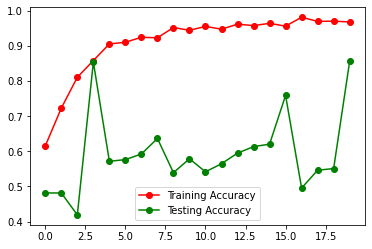

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

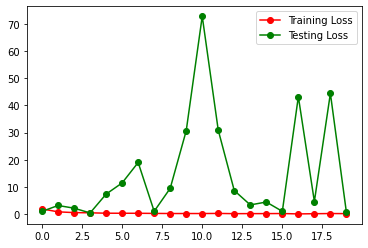

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelDenseNet121.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 3s 636ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.82      0.92      0.87       224
   no-caries       0.90      0.79      0.84       208

   micro avg       0.86      0.86      0.86       432
   macro avg       0.86      0.85      0.86       432
weighted avg       0.86      0.86      0.86       432
 samples avg       0.86      0.86      0.86       432



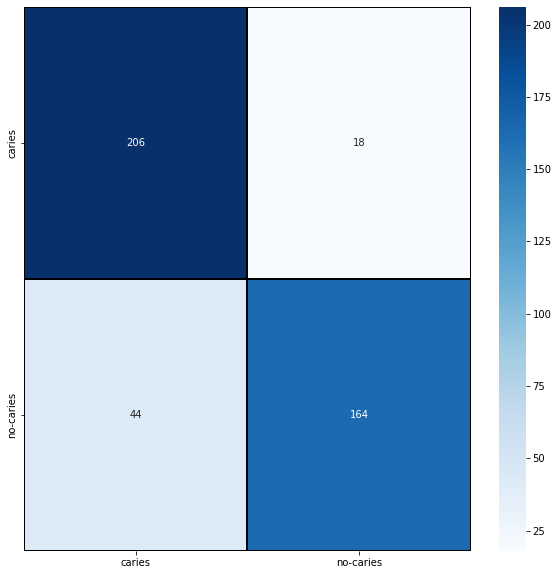

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.8540521978021978


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([0.824    , 0.9010989])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.91964286, 0.78846154])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.86919831, 0.84102564])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

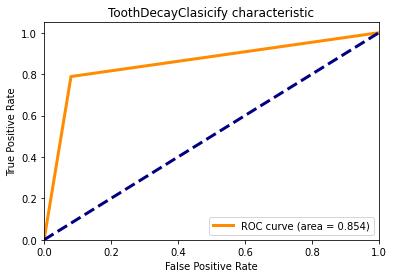

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-148-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


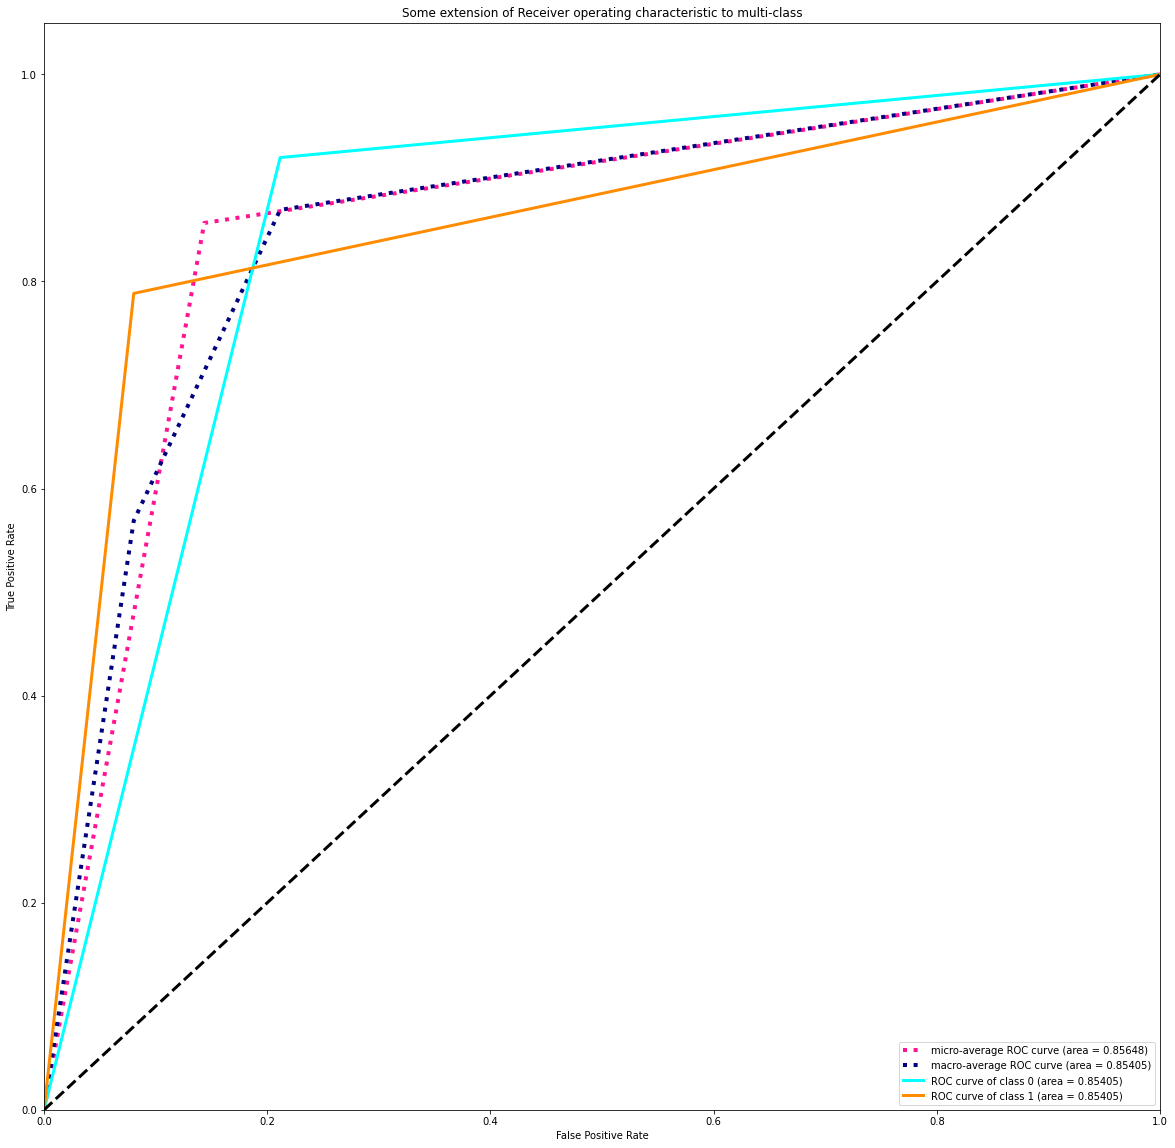

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By DenseNet121 V2 Model


In [ ]:
# using Pre-trained model " DenseNet121 "

In [ ]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),weights='imagenet',include_top=False,classes=2)

# Freeze all the layers of the model
for layer in base_model.layers:
    layer.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
modelDenseNet121 = Sequential()
modelDenseNet121.add(base_model)
modelDenseNet121.add(tf.keras.layers.GlobalAveragePooling2D())
modelDenseNet121.add(Dropout(0.5))
modelDenseNet121.add(Dense(2, activation="softmax"))
modelDenseNet121.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_34 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 7,039,554
Trainable params: 2,050
Non-trainable params: 7,037,504
_________________________________________________________________


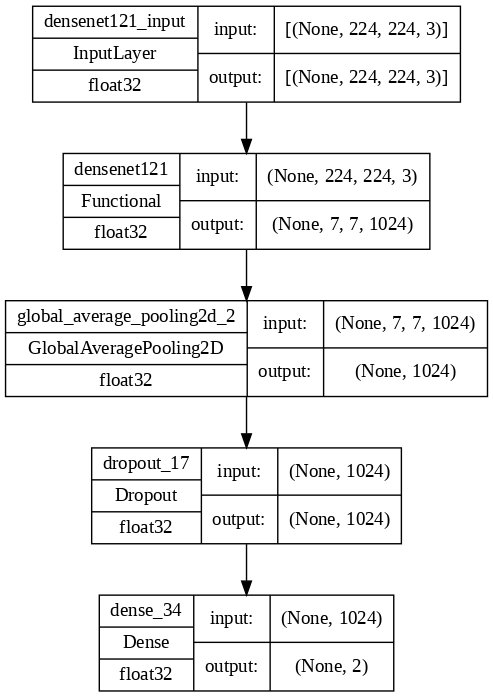

In [ ]:
tf.keras.utils.plot_model(modelDenseNet121, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", dpi = 100 ,to_file='DenseNet121.png')

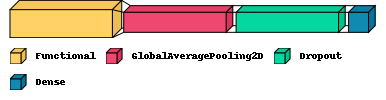

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelDenseNet121, legend=True, font=font,to_file='output_DenseNet121.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam 
modelDenseNet121.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/DenseNet121v2_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_modelv2v2.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelDenseNet121.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.6582
Epoch 1: saving model to best_modelv2v2.h5


127/127 [==============================] - 33s 202ms/step - loss: 0.7206 - accuracy: 0.6582 - val_loss: 0.3318 - val_accuracy: 0.9074
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.7642
Epoch 2: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 177ms/step - loss: 0.5058 - accuracy: 0.7642 - val_loss: 0.2432 - val_accuracy: 0.9329
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8133
Epoch 3: saving model to best_modelv2v2.h5


127/127 [==============================] - 23s 181ms/step - loss: 0.4042 - accuracy: 0.8133 - val_loss: 0.2153 - val_accuracy: 0.9468
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8362
Epoch 4: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 173ms/step - loss: 0.3519 - accuracy: 0.8362 - val_loss: 0.2601 - val_accuracy: 0.8819
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8513
Epoch 5: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.3387 - accuracy: 0.8513 - val_loss: 0.2571 - val_accuracy: 0.8773
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.8568
Epoch 6: saving model to best_modelv2v2.h5


127/127 [==============================] - 23s 185ms/step - loss: 0.3098 - accuracy: 0.8568 - val_loss: 0.1731 - val_accuracy: 0.9653
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8623
Epoch 7: saving model to best_modelv2v2.h5


127/127 [==============================] - 21s 169ms/step - loss: 0.3212 - accuracy: 0.8623 - val_loss: 0.1801 - val_accuracy: 0.9514
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8695
Epoch 8: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 170ms/step - loss: 0.3101 - accuracy: 0.8695 - val_loss: 0.2016 - val_accuracy: 0.9213
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8726
Epoch 9: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 171ms/step - loss: 0.3027 - accuracy: 0.8726 - val_loss: 0.1581 - val_accuracy: 0.9606
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8592
Epoch 10: saving model to best_modelv2v2.h5


127/127 [==============================] - 21s 168ms/step - loss: 0.3150 - accuracy: 0.8592 - val_loss: 0.2402 - val_accuracy: 0.8773
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8623
Epoch 11: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 170ms/step - loss: 0.3146 - accuracy: 0.8623 - val_loss: 0.2078 - val_accuracy: 0.9074
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8687
Epoch 12: saving model to best_modelv2v2.h5


127/127 [==============================] - 23s 184ms/step - loss: 0.3025 - accuracy: 0.8687 - val_loss: 0.1621 - val_accuracy: 0.9583
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8805
Epoch 13: saving model to best_modelv2v2.h5


127/127 [==============================] - 55s 434ms/step - loss: 0.2881 - accuracy: 0.8805 - val_loss: 0.1875 - val_accuracy: 0.9306
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8663
Epoch 14: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 172ms/step - loss: 0.2850 - accuracy: 0.8663 - val_loss: 0.1555 - val_accuracy: 0.9606
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.8774
Epoch 15: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 173ms/step - loss: 0.2899 - accuracy: 0.8774 - val_loss: 0.1561 - val_accuracy: 0.9630
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.8671
Epoch 16: saving model to best_modelv2v2.h5


127/127 [==============================] - 24s 190ms/step - loss: 0.2924 - accuracy: 0.8671 - val_loss: 0.1585 - val_accuracy: 0.9514
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.8892
Epoch 17: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 170ms/step - loss: 0.2646 - accuracy: 0.8892 - val_loss: 0.1497 - val_accuracy: 0.9606
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.8718
Epoch 18: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 170ms/step - loss: 0.2906 - accuracy: 0.8718 - val_loss: 0.1623 - val_accuracy: 0.9421
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8600
Epoch 19: saving model to best_modelv2v2.h5


127/127 [==============================] - 21s 169ms/step - loss: 0.3065 - accuracy: 0.8600 - val_loss: 0.1465 - val_accuracy: 0.9583
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8758
Epoch 20: saving model to best_modelv2v2.h5


127/127 [==============================] - 22s 171ms/step - loss: 0.2831 - accuracy: 0.8758 - val_loss: 0.1404 - val_accuracy: 0.9630


# Plot Accuracy and Loss DenseNet121 V2

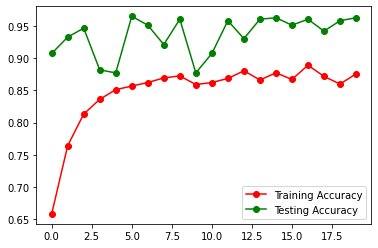

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

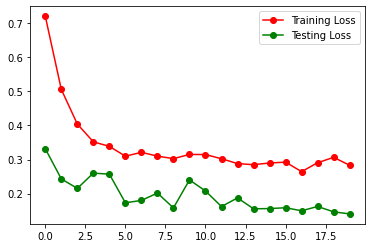

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelDenseNet121.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 3s 679ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.95      0.98      0.96       224
   no-caries       0.98      0.95      0.96       208

   micro avg       0.96      0.96      0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432
 samples avg       0.96      0.96      0.96       432



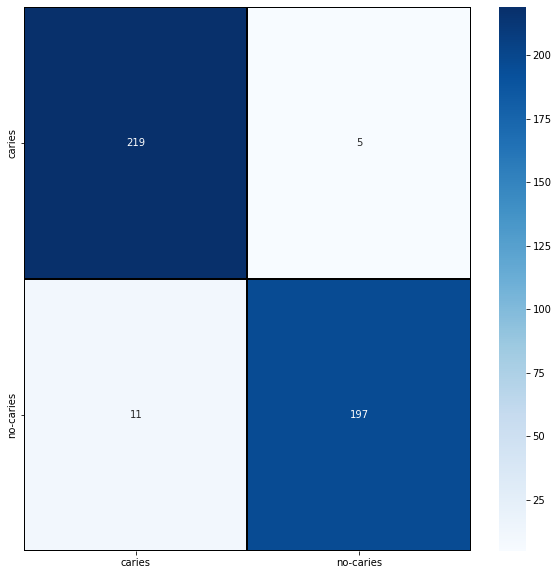

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.9623969780219779


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([0.95217391, 0.97524752])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.97767857, 0.94711538])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.96475771, 0.96097561])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

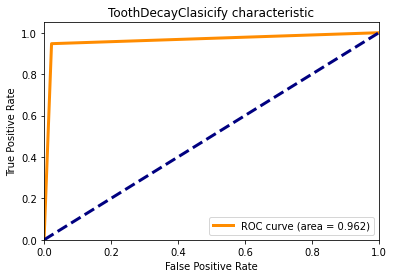

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-374-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


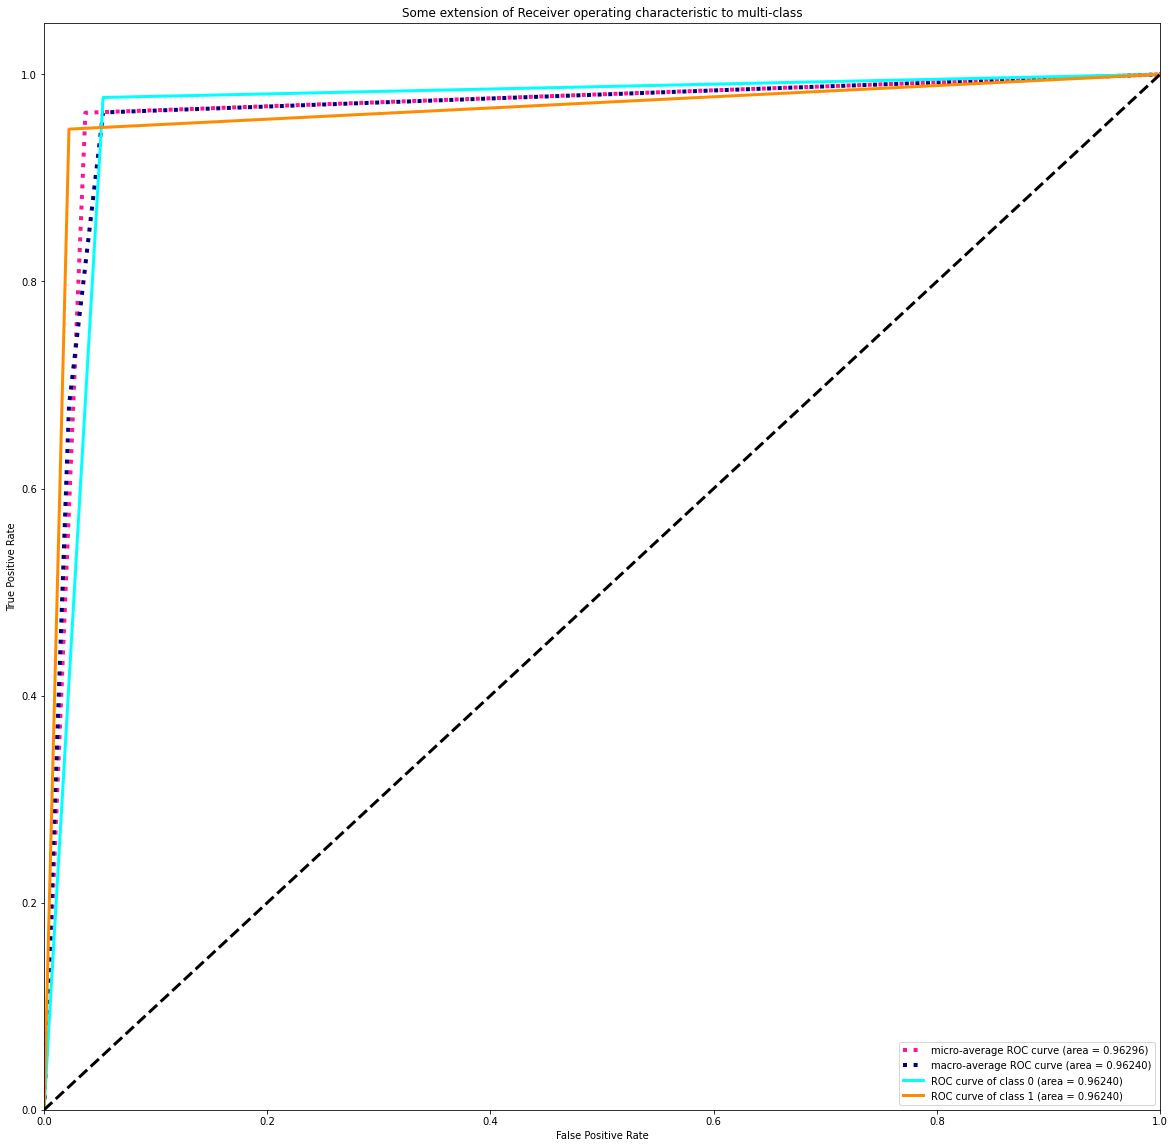

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By CNN Version 1 Model


In [ ]:
from keras import layers

In [ ]:
modelCNNV1 = Sequential()
modelCNNV1.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)))
modelCNNV1.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelCNNV1.add(layers.MaxPooling2D((2, 2)))
modelCNNV1.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelCNNV1.add(layers.MaxPooling2D((2, 2)))
modelCNNV1.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelCNNV1.add(layers.MaxPooling2D((2, 2))) 


modelCNNV1.add(Flatten())
modelCNNV1.add(layers.Dense(512, activation='relu'))
modelCNNV1.add(Dense(2, activation="softmax"))
 
modelCNNV1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)      

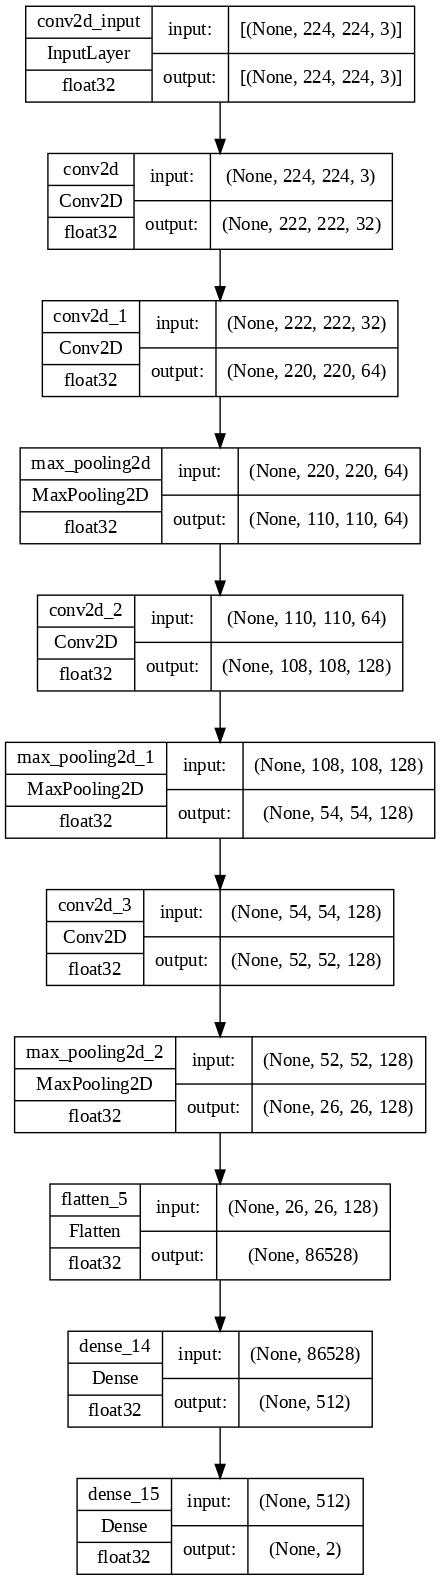

In [ ]:
tf.keras.utils.plot_model(modelCNNV1, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 100 ,to_file='Layer_V1.png')

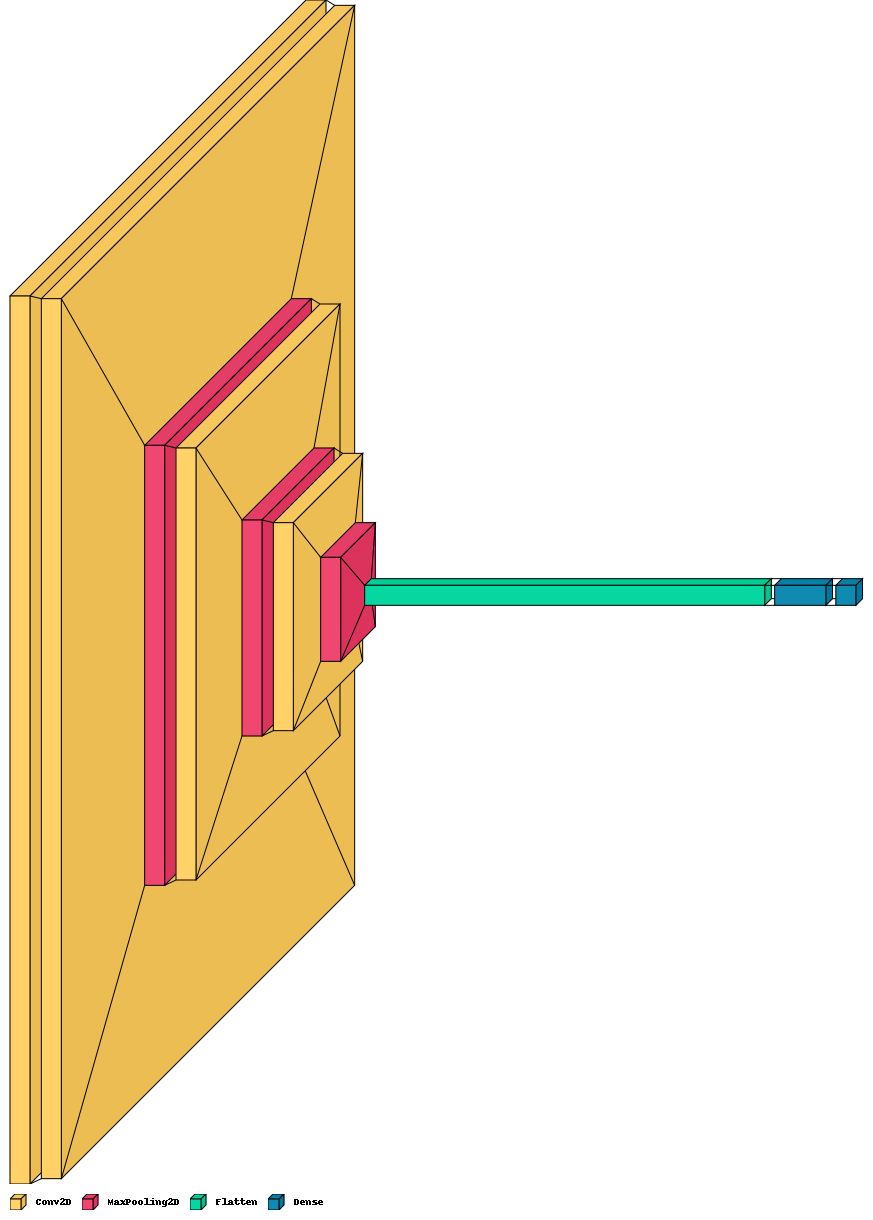

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelCNNV1, legend=True, font=font,to_file='output_Layer_V1.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam = RMSprop = SGD
modelCNNV1.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/Layer_V1_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelCNNV1.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.6638
Epoch 1: saving model to best_model.h5


127/127 [==============================] - 28s 205ms/step - loss: 0.6547 - accuracy: 0.6638 - val_loss: 1.1825 - val_accuracy: 0.5486
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.8093
Epoch 2: saving model to best_model.h5


127/127 [==============================] - 23s 181ms/step - loss: 0.4441 - accuracy: 0.8093 - val_loss: 0.4562 - val_accuracy: 0.8750
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8608
Epoch 3: saving model to best_model.h5


127/127 [==============================] - 22s 170ms/step - loss: 0.3786 - accuracy: 0.8608 - val_loss: 0.2912 - val_accuracy: 0.8819
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8979
Epoch 4: saving model to best_model.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.2815 - accuracy: 0.8979 - val_loss: 0.3851 - val_accuracy: 0.8819
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9019
Epoch 5: saving model to best_model.h5


127/127 [==============================] - 22s 171ms/step - loss: 0.2533 - accuracy: 0.9019 - val_loss: 3.4551 - val_accuracy: 0.5694
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9153
Epoch 6: saving model to best_model.h5


127/127 [==============================] - 24s 188ms/step - loss: 0.2163 - accuracy: 0.9153 - val_loss: 0.2222 - val_accuracy: 0.9074
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9066
Epoch 7: saving model to best_model.h5


127/127 [==============================] - 22s 170ms/step - loss: 0.2085 - accuracy: 0.9066 - val_loss: 0.6696 - val_accuracy: 0.7593
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9462
Epoch 8: saving model to best_model.h5


127/127 [==============================] - 22s 171ms/step - loss: 0.1620 - accuracy: 0.9462 - val_loss: 0.2729 - val_accuracy: 0.9097
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9502
Epoch 9: saving model to best_model.h5


127/127 [==============================] - 22s 171ms/step - loss: 0.1677 - accuracy: 0.9502 - val_loss: 0.7465 - val_accuracy: 0.8565
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9462
Epoch 10: saving model to best_model.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.1555 - accuracy: 0.9462 - val_loss: 0.2779 - val_accuracy: 0.8958
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9454
Epoch 11: saving model to best_model.h5


127/127 [==============================] - 22s 173ms/step - loss: 0.1412 - accuracy: 0.9454 - val_loss: 0.4303 - val_accuracy: 0.7894
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9636
Epoch 12: saving model to best_model.h5


127/127 [==============================] - 22s 173ms/step - loss: 0.1285 - accuracy: 0.9636 - val_loss: 0.2047 - val_accuracy: 0.9491
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9581
Epoch 13: saving model to best_model.h5


127/127 [==============================] - 24s 187ms/step - loss: 0.1282 - accuracy: 0.9581 - val_loss: 0.2178 - val_accuracy: 0.9560
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9684
Epoch 14: saving model to best_model.h5


127/127 [==============================] - 23s 181ms/step - loss: 0.1065 - accuracy: 0.9684 - val_loss: 0.2434 - val_accuracy: 0.9190
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9604
Epoch 15: saving model to best_model.h5


127/127 [==============================] - 22s 172ms/step - loss: 0.1278 - accuracy: 0.9604 - val_loss: 0.2075 - val_accuracy: 0.9583
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9620
Epoch 16: saving model to best_model.h5


127/127 [==============================] - 23s 180ms/step - loss: 0.1154 - accuracy: 0.9620 - val_loss: 0.1532 - val_accuracy: 0.9630
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9691
Epoch 17: saving model to best_model.h5


127/127 [==============================] - 22s 171ms/step - loss: 0.1009 - accuracy: 0.9691 - val_loss: 0.2826 - val_accuracy: 0.9352
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9707
Epoch 18: saving model to best_model.h5


127/127 [==============================] - 22s 173ms/step - loss: 0.1016 - accuracy: 0.9707 - val_loss: 0.1839 - val_accuracy: 0.9329
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9660
Epoch 19: saving model to best_model.h5


127/127 [==============================] - 24s 186ms/step - loss: 0.0910 - accuracy: 0.9660 - val_loss: 0.3169 - val_accuracy: 0.9213
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9684
Epoch 20: saving model to best_model.h5


127/127 [==============================] - 22s 173ms/step - loss: 0.1218 - accuracy: 0.9684 - val_loss: 0.3892 - val_accuracy: 0.8935


# Plot Accuracy and Loss Layer_V1

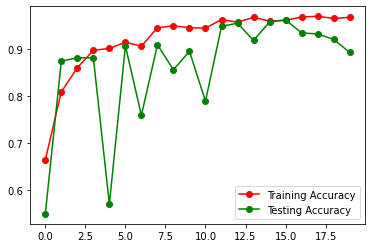

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

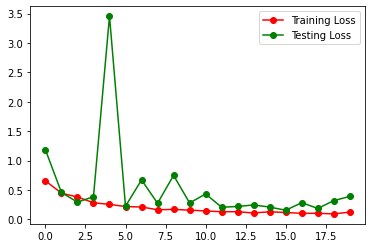

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelCNNV1.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 1s 586ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.87      0.93      0.90       224
   no-caries       0.92      0.86      0.89       208

   micro avg       0.89      0.89      0.89       432
   macro avg       0.90      0.89      0.89       432
weighted avg       0.89      0.89      0.89       432
 samples avg       0.89      0.89      0.89       432



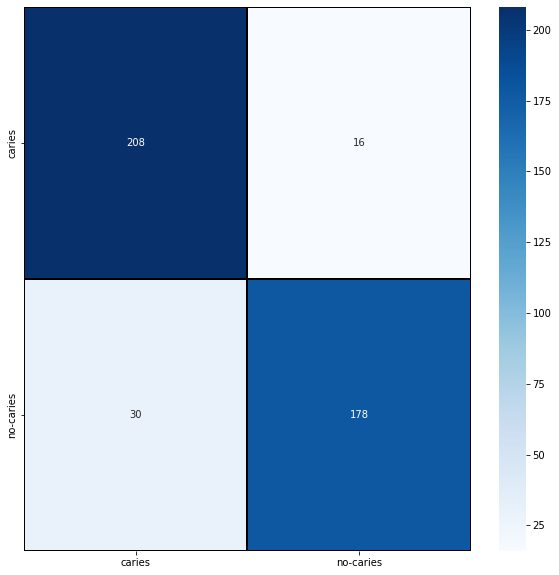

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.8921703296703297


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([0.87394958, 0.91752577])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.92857143, 0.85576923])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.9004329 , 0.88557214])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

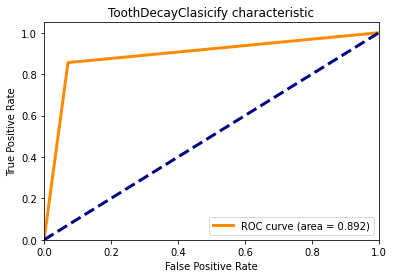

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-172-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


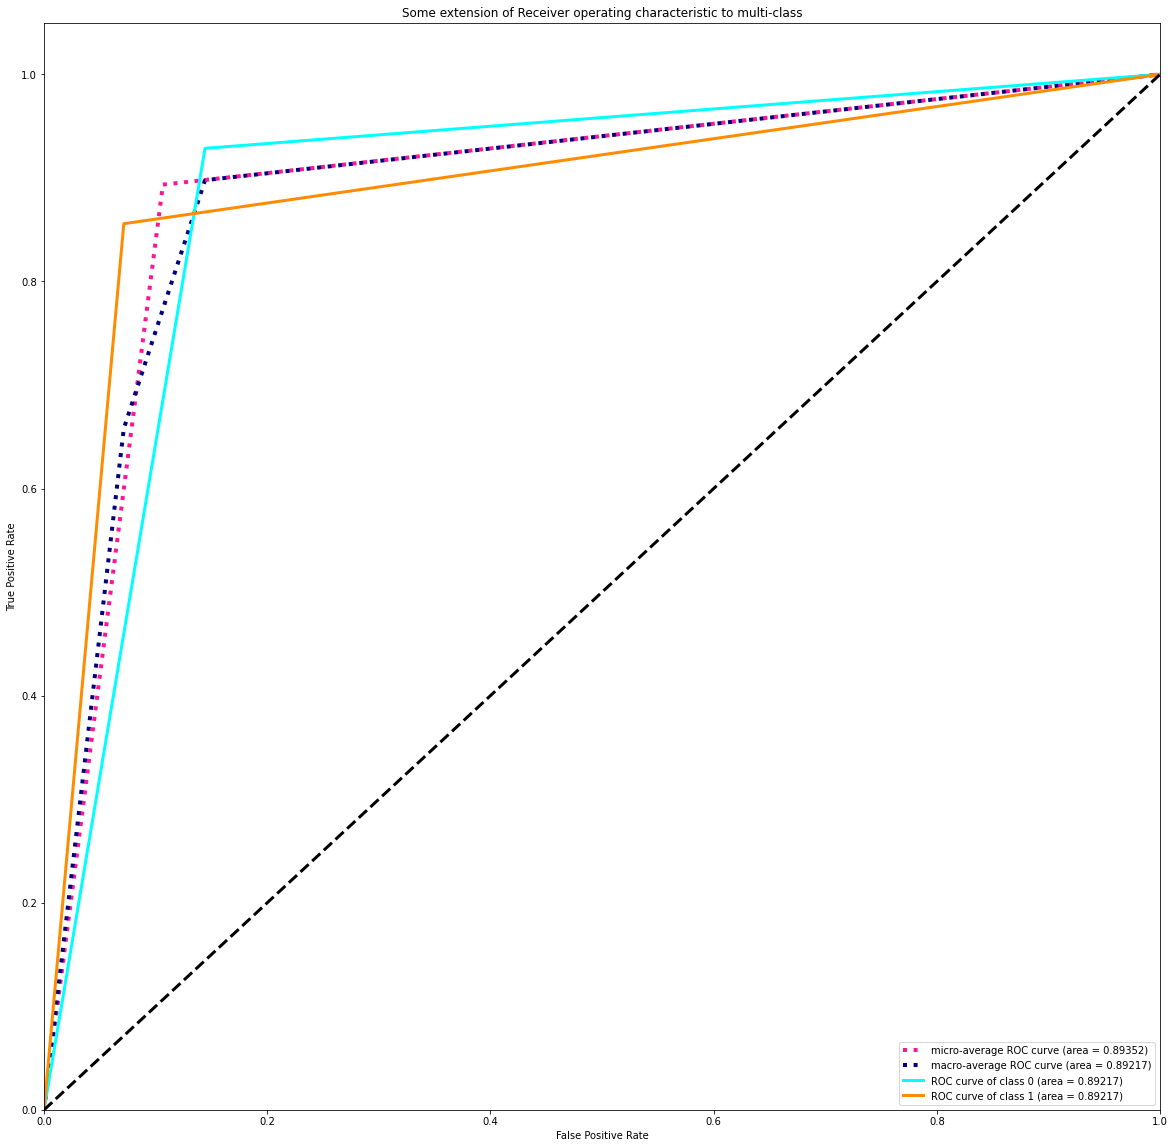

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By CNN Version 2 Model


In [ ]:
from keras import layers

In [ ]:
  modelCNNV2 = Sequential()
  modelCNNV2.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(224, 224, 3)))
  modelCNNV2.add(layers.BatchNormalization())
  modelCNNV2.add(layers.Conv2D(128, (3, 3), activation='relu',strides=(2,2)))
  modelCNNV2.add(layers.BatchNormalization())
  modelCNNV2.add(layers.Conv2D(256, (3, 3), activation='relu',strides=(2,2)))
  modelCNNV2.add(layers.BatchNormalization())
  modelCNNV2.add(layers.Conv2D(512, (3, 3), activation='relu',strides=(2,2)))
  modelCNNV2.add(layers.BatchNormalization())
  modelCNNV2.add(tf.keras.layers.GlobalMaxPooling2D())
  modelCNNV2.add(layers.Dense(512, activation='relu'))
  modelCNNV2.add(layers.Dropout(0.5))
  modelCNNV2.add(Dense(2, activation="softmax"))
  modelCNNV2.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_21 (Conv2D)          (None, 110, 110, 128)     73856     
                                                                 
 batch_normalization_9 (Batc  (None, 110, 110, 128)    512       
 hNormalization)                                                 
                                                                 
 conv2d_22 (Conv2D)          (None, 54, 54, 256)       295168    
                                                                 
 batch_normalization_10 (Bat  (None, 54, 54, 256)    

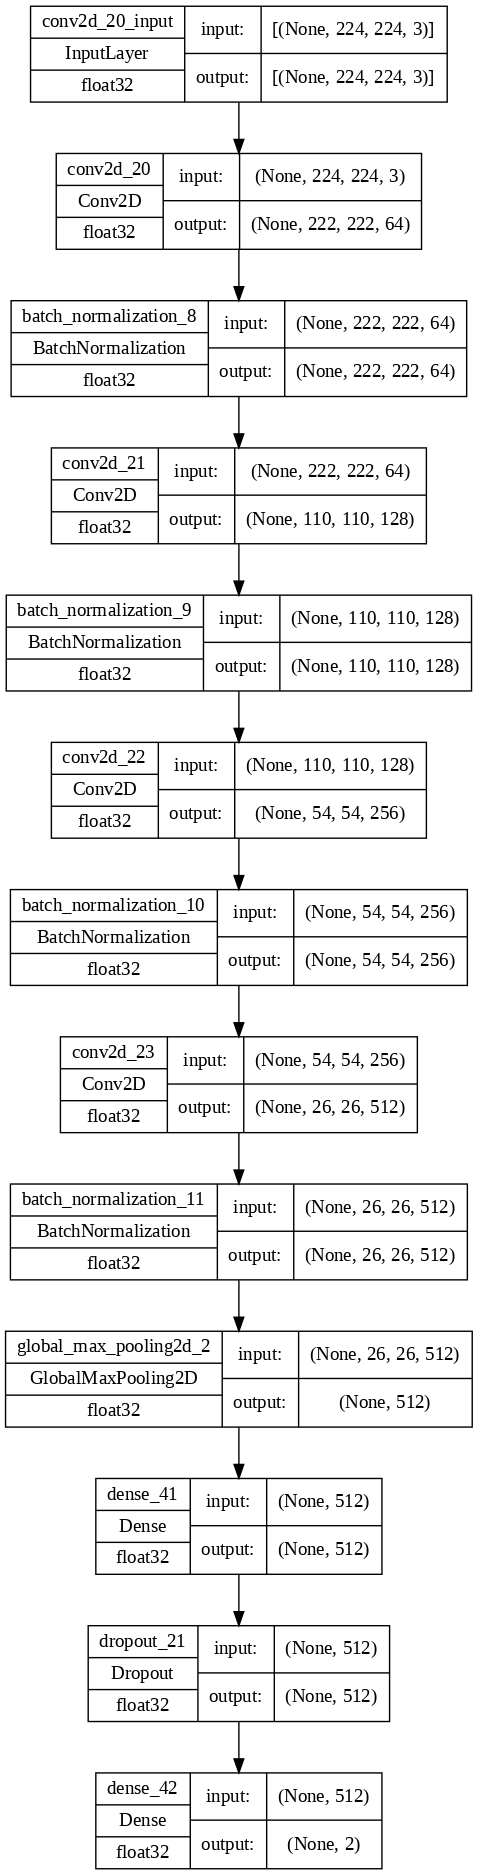

In [ ]:
tf.keras.utils.plot_model(modelCNNV2, show_shapes = True, show_dtype = True, show_layer_names = True,  expand_nested = True, dpi = 100 ,to_file='Layer_V2.png')

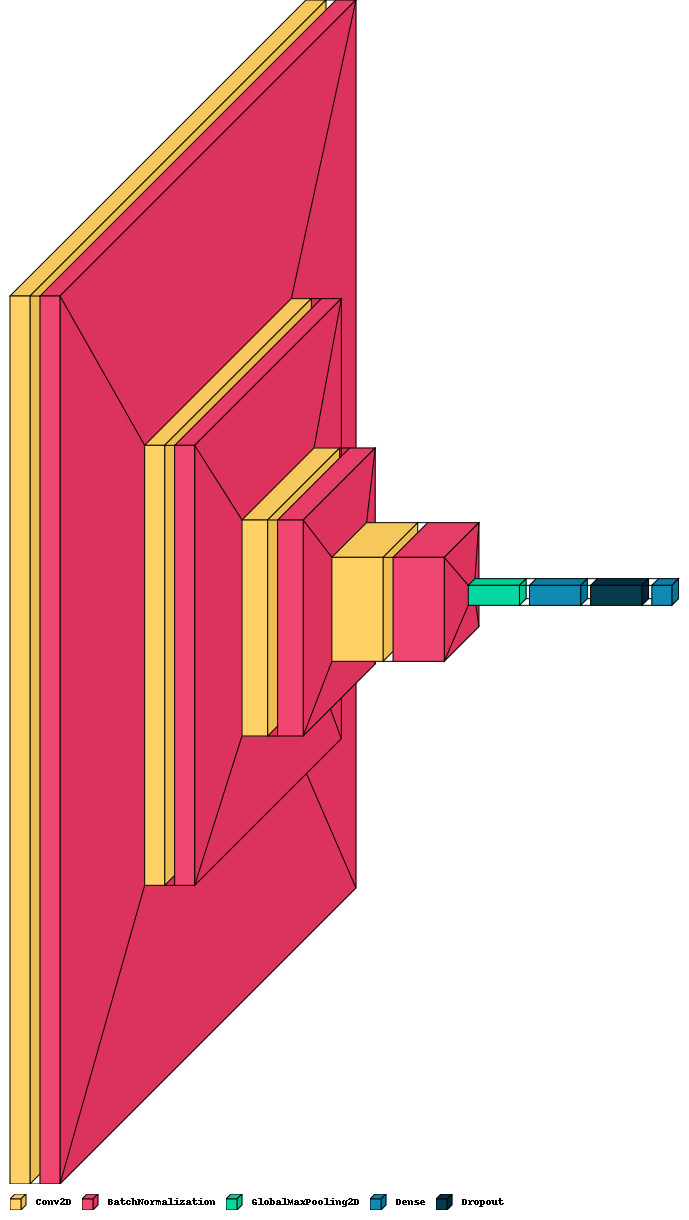

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelCNNV2, legend=True, font=font,to_file='output_Layer_V2.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam = RMSprop = SGD
modelCNNV2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/Layer_V22_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_Layer_V22.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelCNNV2.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 1.4622 - accuracy: 0.5237
Epoch 1: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 27s 203ms/step - loss: 1.4622 - accuracy: 0.5237 - val_loss: 0.7320 - val_accuracy: 0.4606
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.5585
Epoch 2: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 23s 182ms/step - loss: 0.7782 - accuracy: 0.5585 - val_loss: 0.7274 - val_accuracy: 0.5162
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5443
Epoch 3: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 21s 168ms/step - loss: 0.6927 - accuracy: 0.5443 - val_loss: 0.6787 - val_accuracy: 0.5787
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.5957
Epoch 4: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 21s 167ms/step - loss: 0.6670 - accuracy: 0.5957 - val_loss: 0.6339 - val_accuracy: 0.6505
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.5997
Epoch 5: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 23s 179ms/step - loss: 0.6633 - accuracy: 0.5997 - val_loss: 0.6203 - val_accuracy: 0.6898
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6195
Epoch 6: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 21s 167ms/step - loss: 0.6665 - accuracy: 0.6195 - val_loss: 0.6317 - val_accuracy: 0.5926
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.6282
Epoch 7: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 21s 168ms/step - loss: 0.6591 - accuracy: 0.6282 - val_loss: 0.5955 - val_accuracy: 0.7060
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6432
Epoch 8: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 23s 181ms/step - loss: 0.6358 - accuracy: 0.6432 - val_loss: 0.5880 - val_accuracy: 0.6829
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.6804
Epoch 9: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 21s 168ms/step - loss: 0.5940 - accuracy: 0.6804 - val_loss: 0.6849 - val_accuracy: 0.5926
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.6891
Epoch 10: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 22s 173ms/step - loss: 0.5663 - accuracy: 0.6891 - val_loss: 1.3971 - val_accuracy: 0.4815
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7089
Epoch 11: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 32s 253ms/step - loss: 0.5348 - accuracy: 0.7089 - val_loss: 0.5843 - val_accuracy: 0.7269
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.7302
Epoch 12: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 32s 248ms/step - loss: 0.5251 - accuracy: 0.7302 - val_loss: 0.5768 - val_accuracy: 0.6551
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.7555
Epoch 13: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 22s 172ms/step - loss: 0.4737 - accuracy: 0.7555 - val_loss: 1.2151 - val_accuracy: 0.4815
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7627
Epoch 14: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 21s 168ms/step - loss: 0.5130 - accuracy: 0.7627 - val_loss: 1.0115 - val_accuracy: 0.5694
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8133
Epoch 15: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 21s 166ms/step - loss: 0.4126 - accuracy: 0.8133 - val_loss: 0.6201 - val_accuracy: 0.6458
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8014
Epoch 16: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 22s 171ms/step - loss: 0.4212 - accuracy: 0.8014 - val_loss: 0.4802 - val_accuracy: 0.7199
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8378
Epoch 17: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 22s 169ms/step - loss: 0.3824 - accuracy: 0.8378 - val_loss: 0.7403 - val_accuracy: 0.6644
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8307
Epoch 18: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 23s 182ms/step - loss: 0.3860 - accuracy: 0.8307 - val_loss: 0.4780 - val_accuracy: 0.7616
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8544
Epoch 19: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 32s 254ms/step - loss: 0.3462 - accuracy: 0.8544 - val_loss: 1.2851 - val_accuracy: 0.6088
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8434
Epoch 20: saving model to best_model_Layer_V22.h5


127/127 [==============================] - 33s 259ms/step - loss: 0.3702 - accuracy: 0.8434 - val_loss: 0.9022 - val_accuracy: 0.5301


# Plot Accuracy and Loss Layer_V2




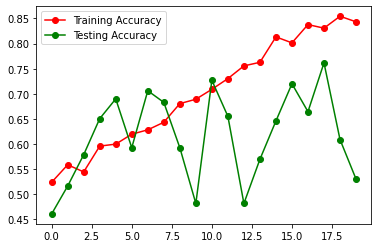

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

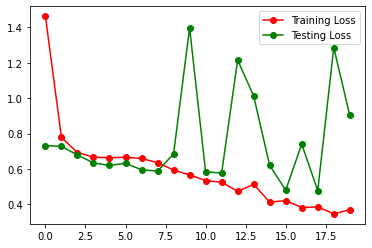

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
for i in range(5):
    img, label = pic.next()
    ax[i].imshow(img[0])
    ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelCNNV2.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 1s 602ms/step


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.89      0.11      0.19       224
   no-caries       0.51      0.99      0.67       208

   micro avg       0.53      0.53      0.53       432
   macro avg       0.70      0.55      0.43       432
weighted avg       0.70      0.53      0.42       432
 samples avg       0.53      0.53      0.53       432



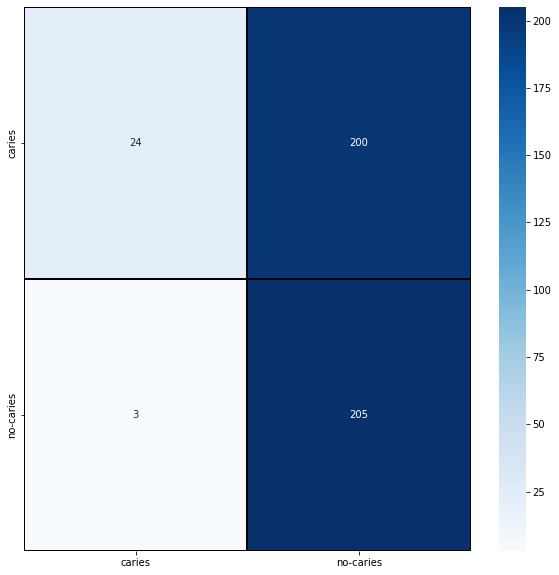

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.5463598901098901


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([0.88888889, 0.50617284])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.10714286, 0.98557692])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.19123506, 0.66884176])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

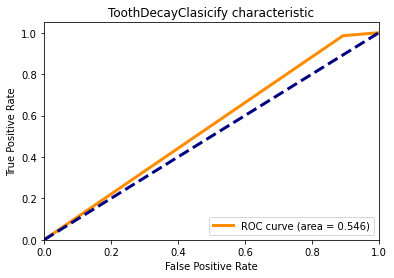

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-446-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


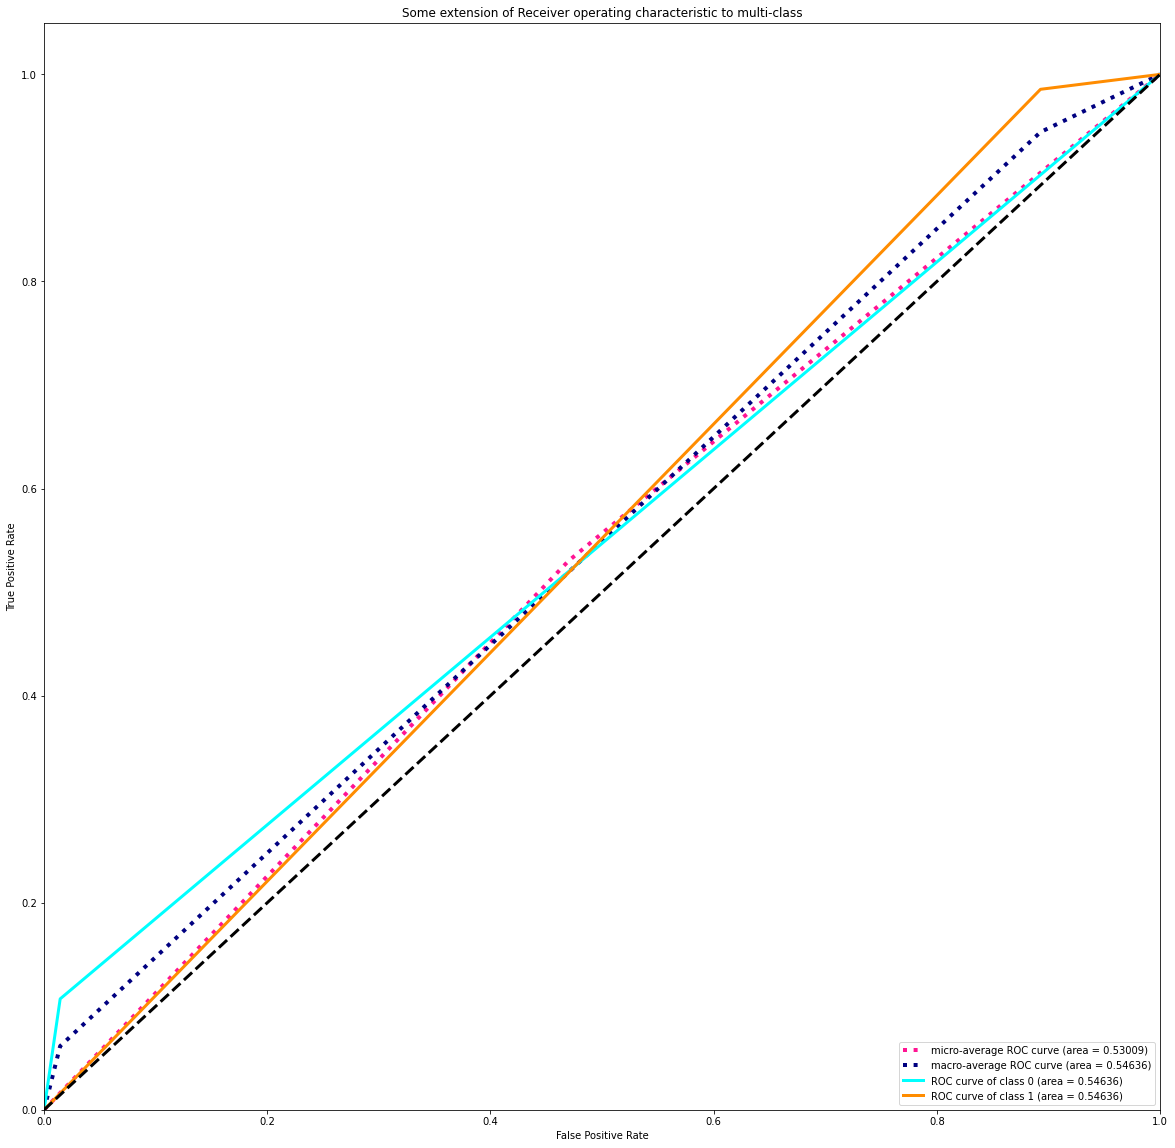

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By VGG19 V2 Model



In [ ]:
# https://keras.io/api/applications/
base_model_vgg16v2 = tf.keras.applications.VGG19(input_shape=(224, 224, 3),weights='imagenet',include_top=False,classes=2)


# Freeze all the layers of the VGG19 model
for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
modelVGG19v2 = Sequential()
modelVGG19v2.add(base_model_vgg16v2)
modelVGG19v2.add(Flatten()) 
modelVGG19v2.add(Dense(512, activation='relu'))
modelVGG19v2.add(Dense(2, activation="softmax"))
modelVGG19v2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 512)               12845568  
                                                                 
 dense_23 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 32,870,978
Trainable params: 32,870,978
Non-trainable params: 0
_________________________________________________________________


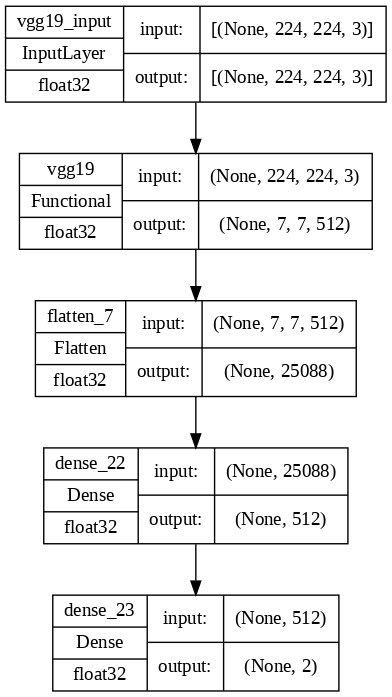

In [ ]:
tf.keras.utils.plot_model(modelVGG19v2, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB",  dpi = 100 ,to_file='VGG19.png')

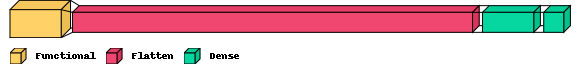

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelVGG19v2, legend=True, font=font,to_file='output_VGG19v2.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam 
modelVGG19v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)



In [ ]:
path_checkpoint = 'tmp/VGG19v2_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_VGG19v2.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelVGG19v2.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.5103
Epoch 1: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 31s 238ms/step - loss: 0.7226 - accuracy: 0.5103 - val_loss: 0.6951 - val_accuracy: 0.4815
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.4517
Epoch 2: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 233ms/step - loss: 0.6966 - accuracy: 0.4517 - val_loss: 0.6920 - val_accuracy: 0.5185
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5047
Epoch 3: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 31s 243ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6930 - val_accuracy: 0.5185
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4945
Epoch 4: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 232ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6930 - val_accuracy: 0.5185
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 5: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 233ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6930 - val_accuracy: 0.5185
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 6: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 233ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6930 - val_accuracy: 0.5185
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 7: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 8: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 31s 246ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 9: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 10: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 236ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 11: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 12: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 13: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 31s 245ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 14: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 15: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5063
Epoch 16: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 17: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 233ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 18: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 31s 244ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 19: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 232ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5063
Epoch 20: saving model to best_model_VGG19v2.h5


127/127 [==============================] - 30s 234ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5185


# Plot Accuracy and Loss VGG19 V2

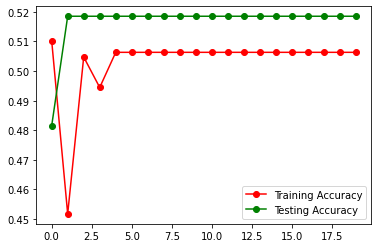

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

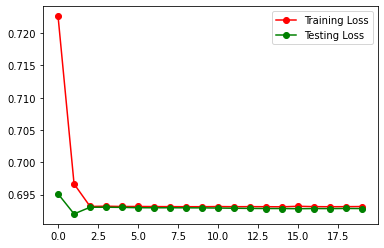

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
for i in range(5):
  img, label = pic.next()
  ax[i].imshow(img[0])
  ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelVGG19v2.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 2s 1s/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.52      1.00      0.68       224
   no-caries       0.00      0.00      0.00       208

   micro avg       0.52      0.52      0.52       432
   macro avg       0.26      0.50      0.34       432
weighted avg       0.27      0.52      0.35       432
 samples avg       0.52      0.52      0.52       432



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


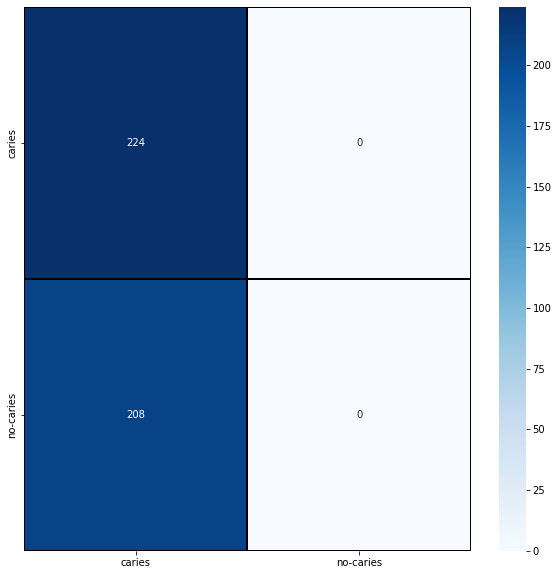

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.5


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.51851852, 0.        ])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([1., 0.])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.68292683, 0.        ])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

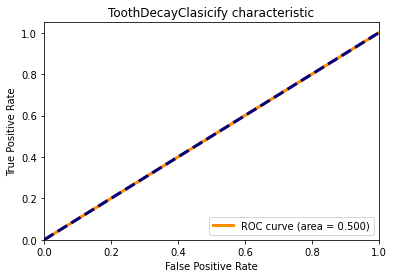

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-225-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


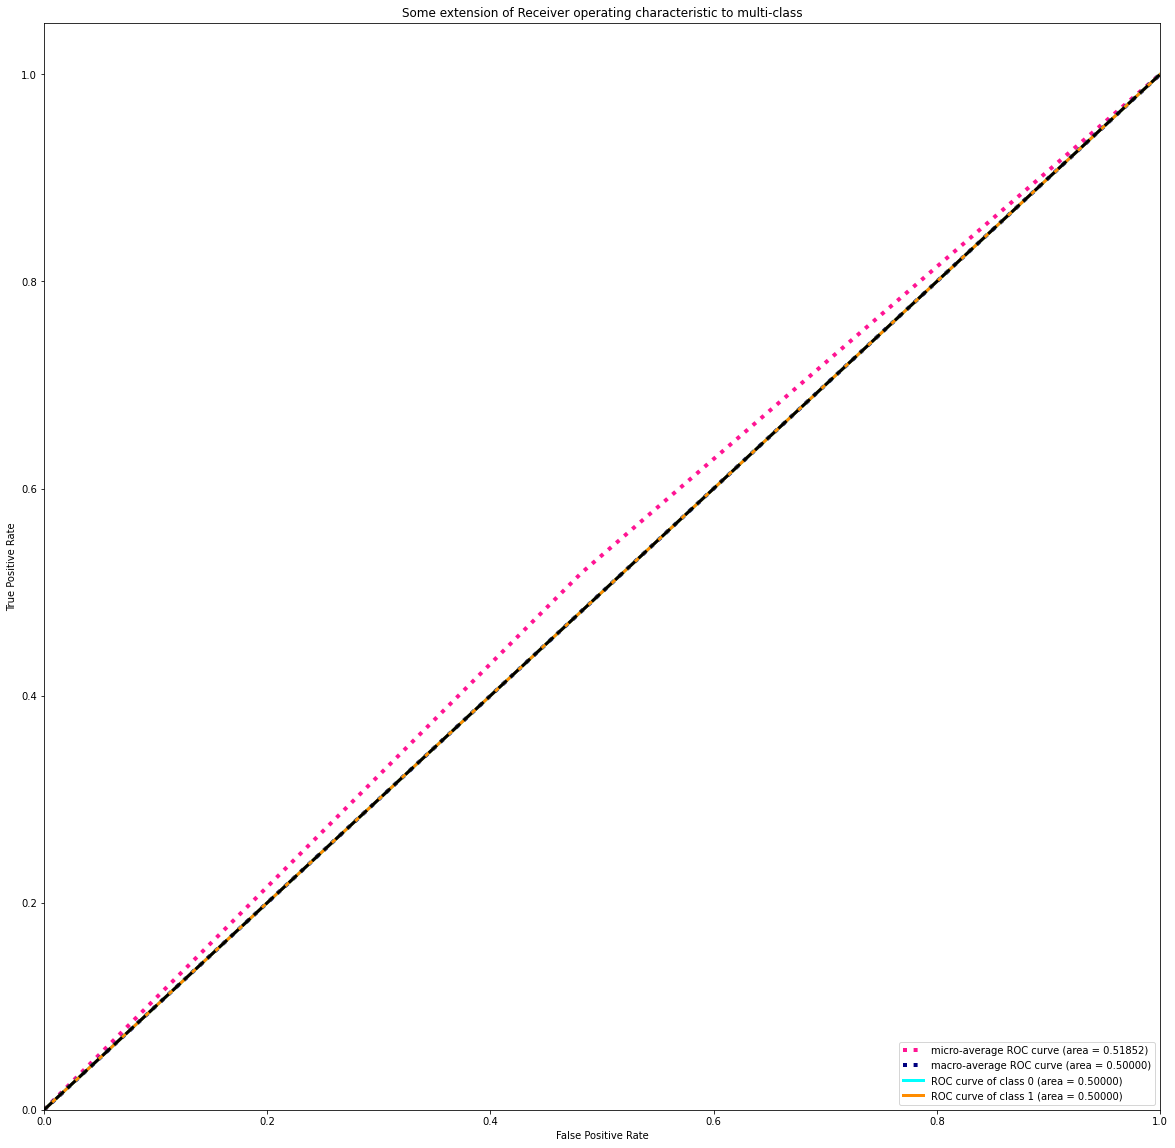

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By VGG16 v2 Model

In [ ]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3),weights='imagenet',include_top=False)



# Freeze all the layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
modelVGG16v2 = Sequential()
modelVGG16v2.add(base_model)
modelVGG16v2.add(Flatten())
modelVGG16v2.add(Dense(512, activation="relu"))
modelVGG16v2.add(Dense(2, activation="softmax"))
modelVGG16v2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 512)               12845568  
                                                                 
 dense_25 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 27,561,282
Trainable params: 12,846,594
Non-trainable params: 14,714,688
_________________________________________________________________


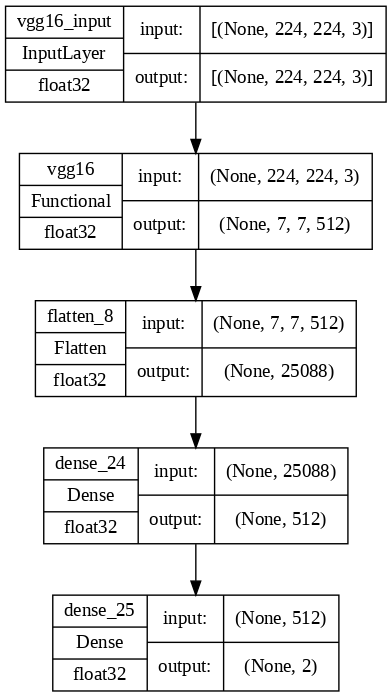

In [ ]:
tf.keras.utils.plot_model(modelVGG16v2, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB",  dpi = 100 ,to_file='VGG16v2.png')

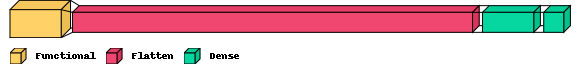

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelVGG16v2, legend=True, font=font,to_file='output_VGG16v2.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam
modelVGG16v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/VGG16_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_modelv2.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelVGG16v2.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.8354
Epoch 1: saving model to best_modelv2.h5


127/127 [==============================] - 24s 183ms/step - loss: 0.3688 - accuracy: 0.8354 - val_loss: 0.2527 - val_accuracy: 0.8912
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9248
Epoch 2: saving model to best_modelv2.h5


127/127 [==============================] - 23s 178ms/step - loss: 0.1854 - accuracy: 0.9248 - val_loss: 0.1236 - val_accuracy: 0.9491
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9233
Epoch 3: saving model to best_modelv2.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1793 - accuracy: 0.9233 - val_loss: 0.1070 - val_accuracy: 0.9560
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9153
Epoch 4: saving model to best_modelv2.h5


127/127 [==============================] - 23s 177ms/step - loss: 0.1991 - accuracy: 0.9153 - val_loss: 0.1006 - val_accuracy: 0.9606
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9185
Epoch 5: saving model to best_modelv2.h5


127/127 [==============================] - 22s 175ms/step - loss: 0.2349 - accuracy: 0.9185 - val_loss: 0.1401 - val_accuracy: 0.9537
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9122
Epoch 6: saving model to best_modelv2.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.2204 - accuracy: 0.9122 - val_loss: 0.2149 - val_accuracy: 0.9097
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9391
Epoch 7: saving model to best_modelv2.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.1547 - accuracy: 0.9391 - val_loss: 0.0845 - val_accuracy: 0.9653
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9525
Epoch 8: saving model to best_modelv2.h5


127/127 [==============================] - 24s 189ms/step - loss: 0.1102 - accuracy: 0.9525 - val_loss: 0.1251 - val_accuracy: 0.9583
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9328
Epoch 9: saving model to best_modelv2.h5


127/127 [==============================] - 22s 175ms/step - loss: 0.1677 - accuracy: 0.9328 - val_loss: 0.1045 - val_accuracy: 0.9537
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9509
Epoch 10: saving model to best_modelv2.h5


127/127 [==============================] - 23s 178ms/step - loss: 0.1216 - accuracy: 0.9509 - val_loss: 0.0675 - val_accuracy: 0.9699
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9573
Epoch 11: saving model to best_modelv2.h5


127/127 [==============================] - 23s 177ms/step - loss: 0.1025 - accuracy: 0.9573 - val_loss: 0.0839 - val_accuracy: 0.9699
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9541
Epoch 12: saving model to best_modelv2.h5


127/127 [==============================] - 23s 182ms/step - loss: 0.1054 - accuracy: 0.9541 - val_loss: 0.0876 - val_accuracy: 0.9699
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9462
Epoch 13: saving model to best_modelv2.h5


127/127 [==============================] - 23s 177ms/step - loss: 0.1261 - accuracy: 0.9462 - val_loss: 0.1046 - val_accuracy: 0.9653
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9494
Epoch 14: saving model to best_modelv2.h5


127/127 [==============================] - 25s 196ms/step - loss: 0.1198 - accuracy: 0.9494 - val_loss: 0.1000 - val_accuracy: 0.9699
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9533
Epoch 15: saving model to best_modelv2.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1225 - accuracy: 0.9533 - val_loss: 0.1393 - val_accuracy: 0.9468
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9581
Epoch 16: saving model to best_modelv2.h5


127/127 [==============================] - 23s 177ms/step - loss: 0.0950 - accuracy: 0.9581 - val_loss: 0.0878 - val_accuracy: 0.9676
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9478
Epoch 17: saving model to best_modelv2.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1388 - accuracy: 0.9478 - val_loss: 0.0962 - val_accuracy: 0.9606
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9589
Epoch 18: saving model to best_modelv2.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.0973 - accuracy: 0.9589 - val_loss: 0.0941 - val_accuracy: 0.9630
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9533
Epoch 19: saving model to best_modelv2.h5


127/127 [==============================] - 22s 177ms/step - loss: 0.1042 - accuracy: 0.9533 - val_loss: 0.0845 - val_accuracy: 0.9676
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9549
Epoch 20: saving model to best_modelv2.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1034 - accuracy: 0.9549 - val_loss: 0.0847 - val_accuracy: 0.9676


# Plot Accuracy and Loss VGG16 V2

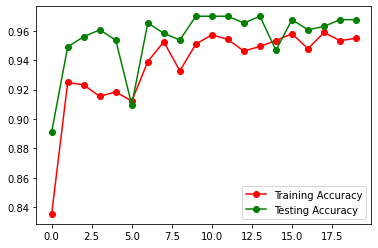

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

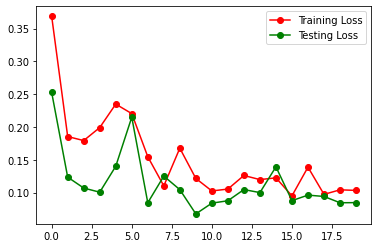

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelVGG16v2.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 2s 1s/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.96      0.98      0.97       224
   no-caries       0.98      0.95      0.97       208

   micro avg       0.97      0.97      0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432
 samples avg       0.97      0.97      0.97       432



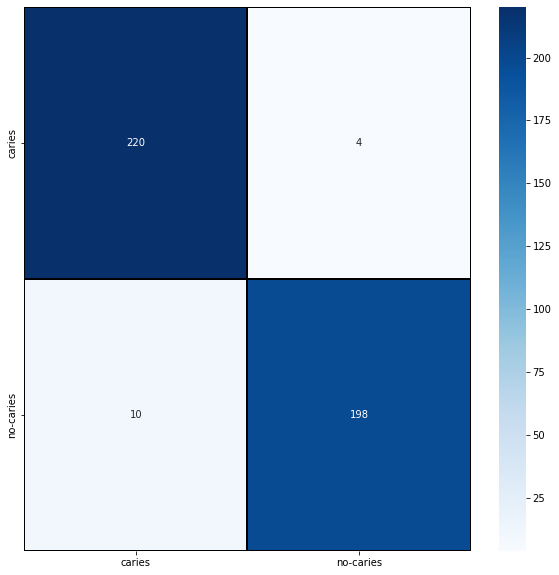

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.9670329670329669


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([0.95652174, 0.98019802])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.98214286, 0.95192308])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.969163  , 0.96585366])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

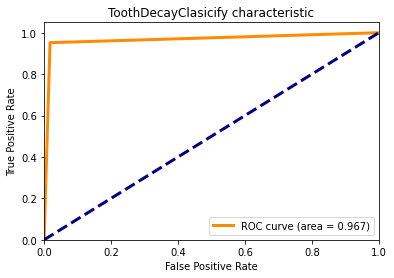

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-249-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


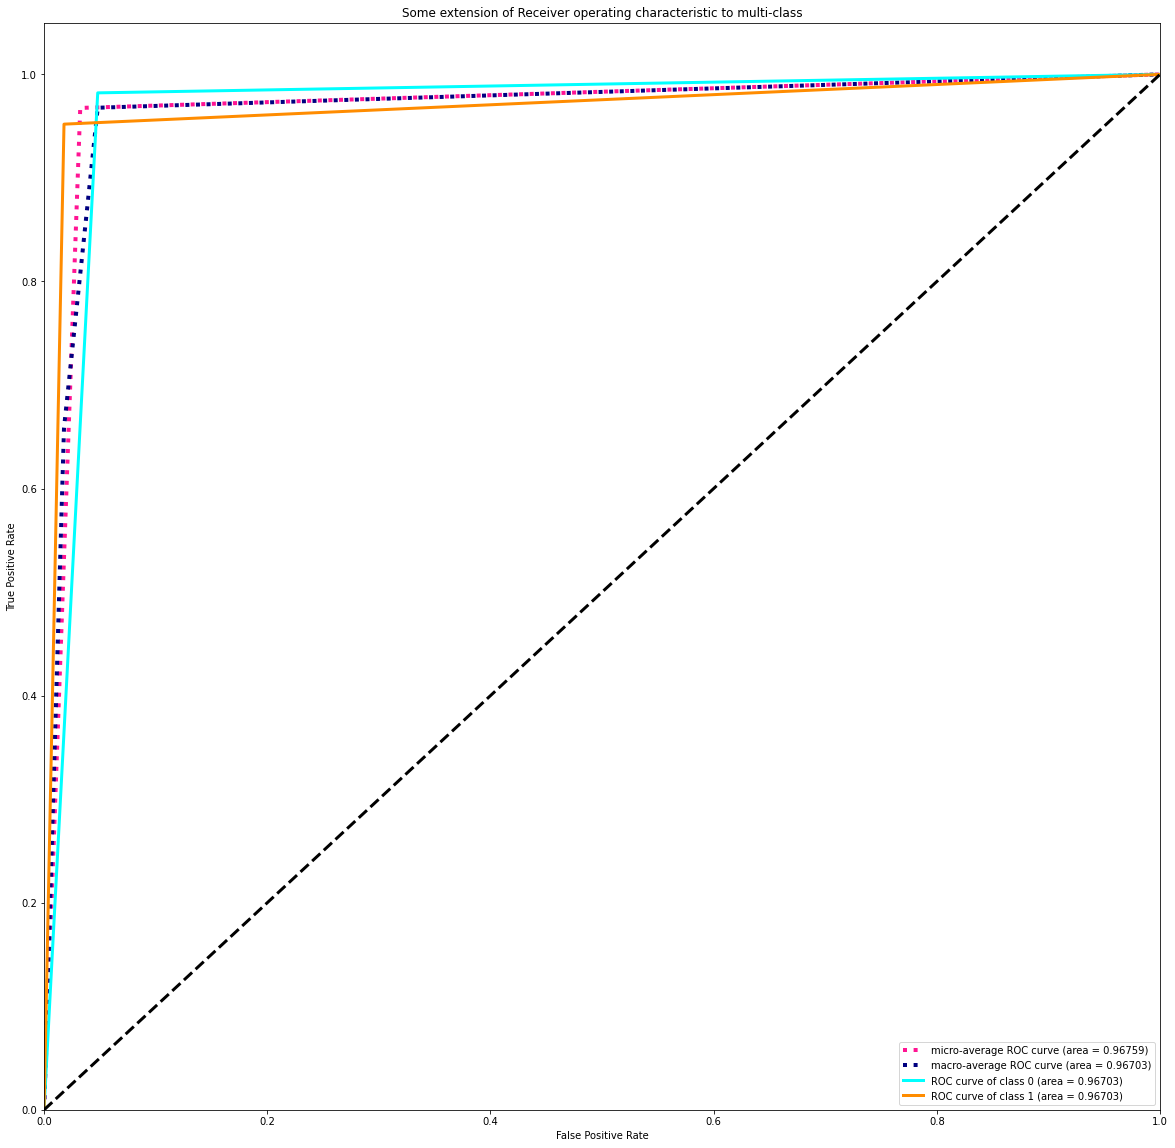

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By VGG16 V3 Model

In [ ]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3),weights='imagenet',include_top=False)



# Freeze all the layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
modelVGG16v3 = Sequential()
modelVGG16v3.add(base_model)
modelVGG16v3.add(Flatten())
modelVGG16v3.add(Dense(512, activation="relu"))
modelVGG16v3.add(Dropout(0.3))
modelVGG16v3.add(Dense(2, activation="softmax"))
modelVGG16v3.summary()



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_26 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 27,561,282
Trainable params: 12,846,594
Non-trainable params: 14,714,688
_________________________________________________________________


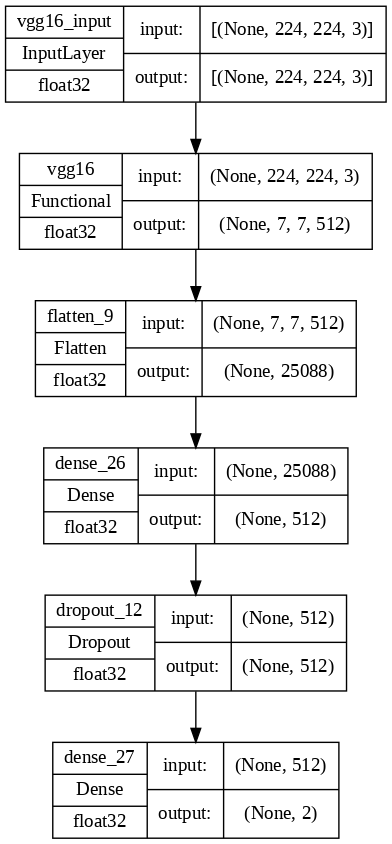

In [ ]:
tf.keras.utils.plot_model(modelVGG16v3, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB",  dpi = 100 ,to_file='VGG16v2.png')

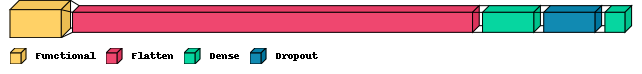

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelVGG16v3, legend=True, font=font,to_file='output_VGG16v3.png')  # font is optional!

In [ ]:
# Functone train 
modelVGG16v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/VGG16v3_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_modelvggv3.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelVGG16v3.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.7911
Epoch 1: saving model to best_modelvggv3.h5


127/127 [==============================] - 25s 193ms/step - loss: 0.4705 - accuracy: 0.7911 - val_loss: 0.3295 - val_accuracy: 0.8472
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8813
Epoch 2: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.2850 - accuracy: 0.8813 - val_loss: 0.1716 - val_accuracy: 0.9213
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9043
Epoch 3: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.2154 - accuracy: 0.9043 - val_loss: 0.2525 - val_accuracy: 0.9028
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9169
Epoch 4: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1996 - accuracy: 0.9169 - val_loss: 0.1179 - val_accuracy: 0.9560
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9351
Epoch 5: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.1705 - accuracy: 0.9351 - val_loss: 0.1043 - val_accuracy: 0.9606
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9343
Epoch 6: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 175ms/step - loss: 0.1613 - accuracy: 0.9343 - val_loss: 0.1765 - val_accuracy: 0.9375
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9422
Epoch 7: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 174ms/step - loss: 0.1523 - accuracy: 0.9422 - val_loss: 0.1062 - val_accuracy: 0.9606
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9185
Epoch 8: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 175ms/step - loss: 0.1899 - accuracy: 0.9185 - val_loss: 0.1004 - val_accuracy: 0.9583
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9454
Epoch 9: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 177ms/step - loss: 0.1349 - accuracy: 0.9454 - val_loss: 0.1775 - val_accuracy: 0.9352
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9430
Epoch 10: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1464 - accuracy: 0.9430 - val_loss: 0.0797 - val_accuracy: 0.9699
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9343
Epoch 11: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 175ms/step - loss: 0.1521 - accuracy: 0.9343 - val_loss: 0.1272 - val_accuracy: 0.9491
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9383
Epoch 12: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 175ms/step - loss: 0.1478 - accuracy: 0.9383 - val_loss: 0.0971 - val_accuracy: 0.9699
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9415
Epoch 13: saving model to best_modelvggv3.h5


127/127 [==============================] - 24s 190ms/step - loss: 0.1215 - accuracy: 0.9415 - val_loss: 0.0956 - val_accuracy: 0.9606
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9478
Epoch 14: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 177ms/step - loss: 0.1278 - accuracy: 0.9478 - val_loss: 0.0962 - val_accuracy: 0.9583
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9415
Epoch 15: saving model to best_modelvggv3.h5


127/127 [==============================] - 23s 178ms/step - loss: 0.1522 - accuracy: 0.9415 - val_loss: 0.0977 - val_accuracy: 0.9630
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9486
Epoch 16: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 177ms/step - loss: 0.1333 - accuracy: 0.9486 - val_loss: 0.0815 - val_accuracy: 0.9699
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9494
Epoch 17: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1363 - accuracy: 0.9494 - val_loss: 0.0831 - val_accuracy: 0.9606
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9597
Epoch 18: saving model to best_modelvggv3.h5


127/127 [==============================] - 24s 190ms/step - loss: 0.1015 - accuracy: 0.9597 - val_loss: 0.1209 - val_accuracy: 0.9398
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9470
Epoch 19: saving model to best_modelvggv3.h5


127/127 [==============================] - 22s 176ms/step - loss: 0.1336 - accuracy: 0.9470 - val_loss: 0.0783 - val_accuracy: 0.9676
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9502
Epoch 20: saving model to best_modelvggv3.h5


127/127 [==============================] - 23s 177ms/step - loss: 0.1116 - accuracy: 0.9502 - val_loss: 0.1388 - val_accuracy: 0.9444


# Plot Accuracy and Loss VGG16 V3

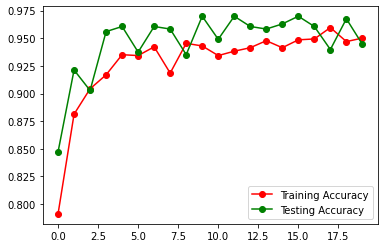

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

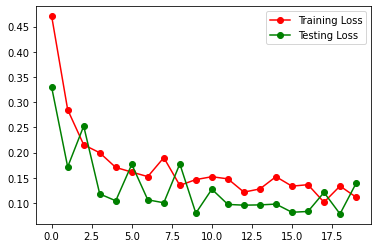

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelVGG16v3.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 2s 1s/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       0.91      1.00      0.95       224
   no-caries       0.99      0.89      0.94       208

   micro avg       0.94      0.94      0.94       432
   macro avg       0.95      0.94      0.94       432
weighted avg       0.95      0.94      0.94       432
 samples avg       0.94      0.94      0.94       432



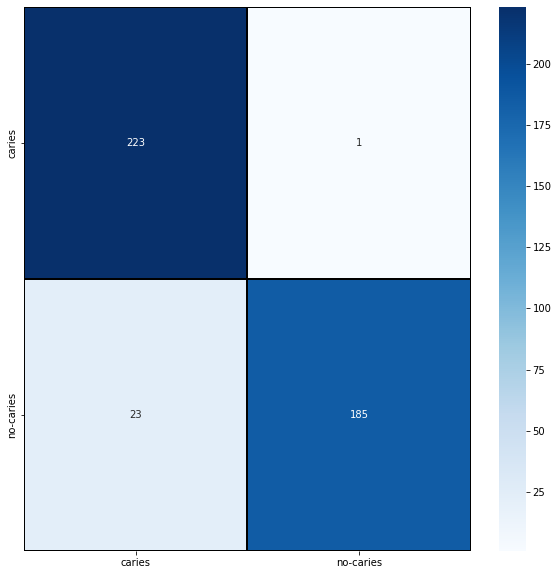

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.9424793956043955


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([0.90650407, 0.99462366])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.99553571, 0.88942308])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.94893617, 0.93908629])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

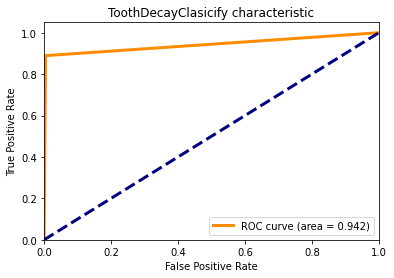

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-273-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


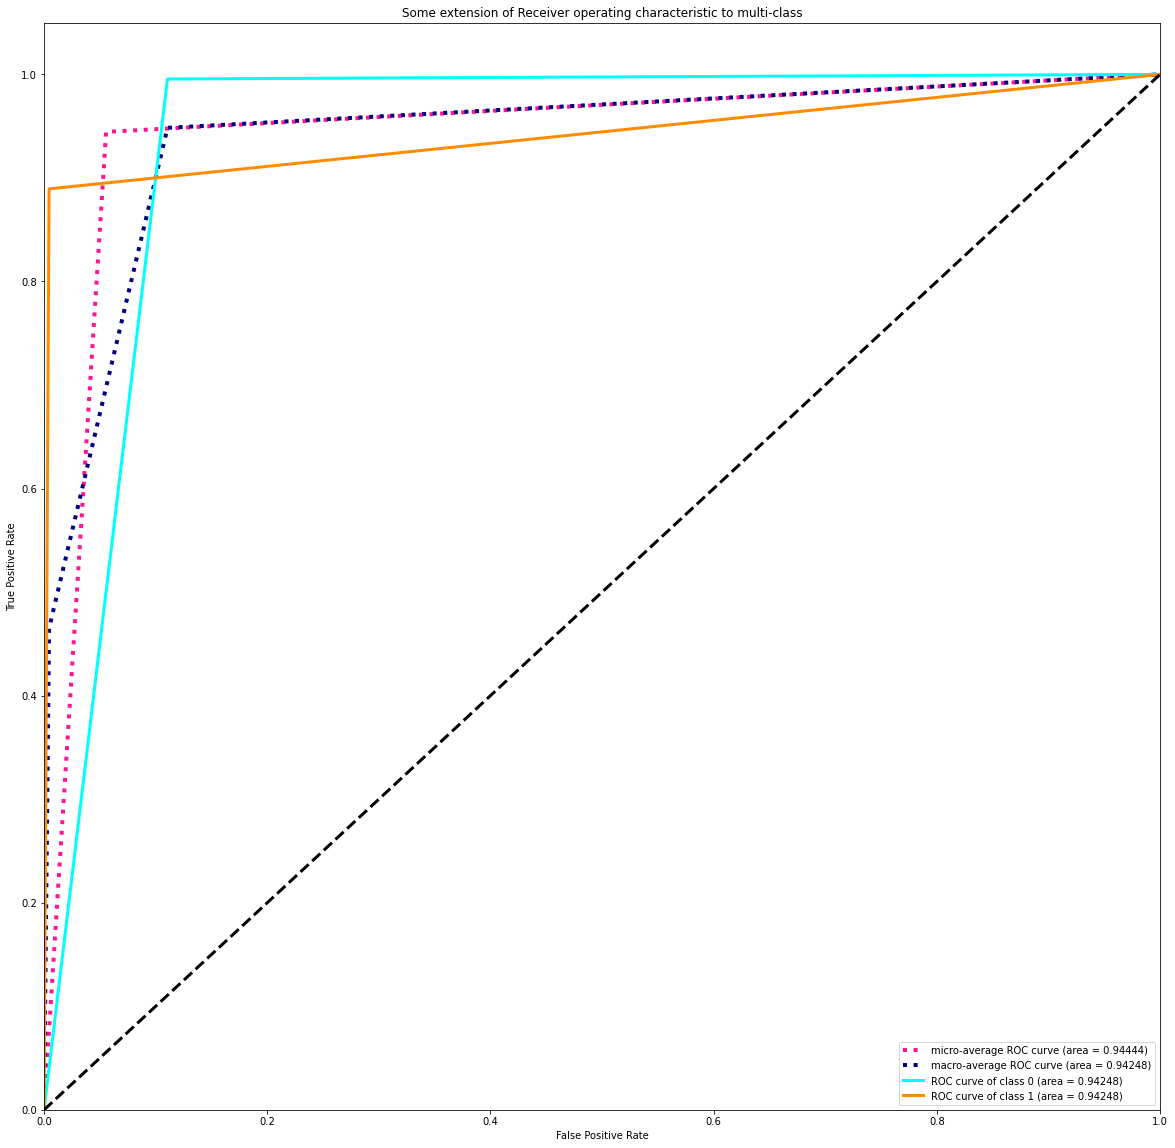

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Train By ResNet50 V2 Model


In [ ]:
# using Pre-trained model " ResNet50 "

In [ ]:
# https://keras.io/api/applications/
base_modelresv2 = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),weights="imagenet",include_top=False,classes=2)

# Freeze all the layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
modelResNet50v2 = Sequential()
modelResNet50v2.add(base_modelresv2)

modelResNet50v2.add(tf.keras.layers.GlobalAveragePooling2D())
modelResNet50v2.add(Dropout(0.5))
modelResNet50v2.add(Dense(2, activation="softmax"))
modelResNet50v2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_28 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


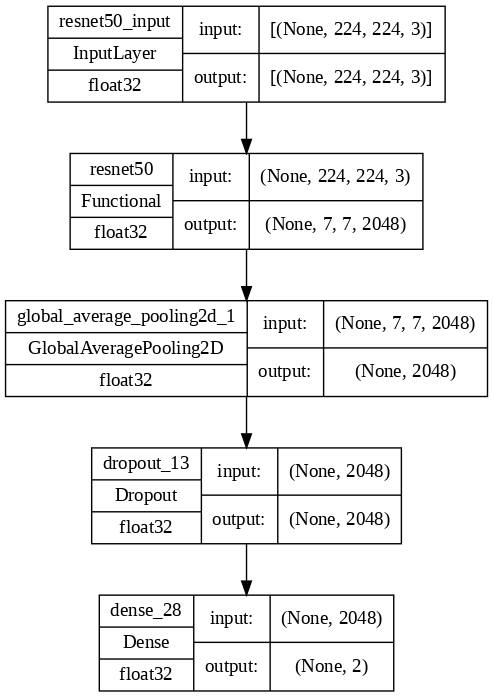

In [ ]:
tf.keras.utils.plot_model(modelResNet50v2, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", dpi = 100 ,to_file='ResNet50.png')

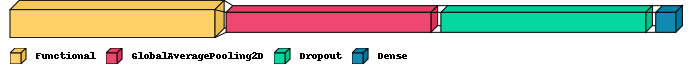

In [ ]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(modelResNet50v2, legend=True, font=font,to_file='output_ResNet50.png')  # font is optional!

In [ ]:
# Functone train
# có thể thay thế Adam 
modelResNet50v2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
path_checkpoint = 'tmp/ResNet50_checkpoint'
os.makedirs(path_checkpoint,exist_ok=True)

# https://keras.io/api/callbacks/model_checkpoint/
# https://www.tensorflow.org/tensorboard/scalars_and_keras
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc',
                                                mode='max',
                                                 verbose=1)
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format('Toothdecay'))]

In [ ]:
history = modelResNet50v2.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=20,
    callbacks=[
        callback
    ])

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 1.1232 - accuracy: 0.6084
Epoch 1: saving model to best_model.h5


127/127 [==============================] - 32s 214ms/step - loss: 1.1232 - accuracy: 0.6084 - val_loss: 4269482.5000 - val_accuracy: 0.5185
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.8518 - accuracy: 0.6646
Epoch 2: saving model to best_model.h5


127/127 [==============================] - 25s 199ms/step - loss: 0.8518 - accuracy: 0.6646 - val_loss: 20.8393 - val_accuracy: 0.4630
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.7516
Epoch 3: saving model to best_model.h5


127/127 [==============================] - 26s 207ms/step - loss: 0.6384 - accuracy: 0.7516 - val_loss: 0.6977 - val_accuracy: 0.4167
Epoch 4/20
127/127 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8180
Epoch 4: saving model to best_model.h5


127/127 [==============================] - 25s 198ms/step - loss: 0.4458 - accuracy: 0.8180 - val_loss: 7.9009 - val_accuracy: 0.4815
Epoch 5/20
127/127 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8884
Epoch 5: saving model to best_model.h5


127/127 [==============================] - 25s 198ms/step - loss: 0.3308 - accuracy: 0.8884 - val_loss: 5.1375 - val_accuracy: 0.4815
Epoch 6/20
127/127 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9288
Epoch 6: saving model to best_model.h5


127/127 [==============================] - 25s 197ms/step - loss: 0.2054 - accuracy: 0.9288 - val_loss: 0.7244 - val_accuracy: 0.4815
Epoch 7/20
127/127 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9422
Epoch 7: saving model to best_model.h5


127/127 [==============================] - 27s 214ms/step - loss: 0.1757 - accuracy: 0.9422 - val_loss: 5.2341 - val_accuracy: 0.4838
Epoch 8/20
127/127 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9581
Epoch 8: saving model to best_model.h5


127/127 [==============================] - 26s 204ms/step - loss: 0.1336 - accuracy: 0.9581 - val_loss: 0.2454 - val_accuracy: 0.9051
Epoch 9/20
127/127 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9494
Epoch 9: saving model to best_model.h5


127/127 [==============================] - 25s 200ms/step - loss: 0.1353 - accuracy: 0.9494 - val_loss: 0.3091 - val_accuracy: 0.9097
Epoch 10/20
127/127 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9320
Epoch 10: saving model to best_model.h5


127/127 [==============================] - 25s 198ms/step - loss: 0.2071 - accuracy: 0.9320 - val_loss: 0.5269 - val_accuracy: 0.7870
Epoch 11/20
127/127 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9676
Epoch 11: saving model to best_model.h5


127/127 [==============================] - 25s 200ms/step - loss: 0.0922 - accuracy: 0.9676 - val_loss: 0.5252 - val_accuracy: 0.9606
Epoch 12/20
127/127 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9549
Epoch 12: saving model to best_model.h5


127/127 [==============================] - 27s 212ms/step - loss: 0.1443 - accuracy: 0.9549 - val_loss: 0.5600 - val_accuracy: 0.6458
Epoch 13/20
127/127 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9367
Epoch 13: saving model to best_model.h5


127/127 [==============================] - 25s 198ms/step - loss: 0.1938 - accuracy: 0.9367 - val_loss: 0.2793 - val_accuracy: 0.9352
Epoch 14/20
127/127 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9454
Epoch 14: saving model to best_model.h5


127/127 [==============================] - 25s 200ms/step - loss: 0.1486 - accuracy: 0.9454 - val_loss: 0.1430 - val_accuracy: 0.9606
Epoch 15/20
127/127 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9723
Epoch 15: saving model to best_model.h5


127/127 [==============================] - 25s 199ms/step - loss: 0.0923 - accuracy: 0.9723 - val_loss: 0.4988 - val_accuracy: 0.9190
Epoch 16/20
127/127 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9407
Epoch 16: saving model to best_model.h5


127/127 [==============================] - 25s 199ms/step - loss: 0.1429 - accuracy: 0.9407 - val_loss: 1.2445 - val_accuracy: 0.6296
Epoch 17/20
127/127 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9604
Epoch 17: saving model to best_model.h5


127/127 [==============================] - 25s 198ms/step - loss: 0.1080 - accuracy: 0.9604 - val_loss: 0.6898 - val_accuracy: 0.8611
Epoch 18/20
127/127 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9628
Epoch 18: saving model to best_model.h5


127/127 [==============================] - 27s 212ms/step - loss: 0.1037 - accuracy: 0.9628 - val_loss: 0.2198 - val_accuracy: 0.9583
Epoch 19/20
127/127 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9747
Epoch 19: saving model to best_model.h5


127/127 [==============================] - 25s 199ms/step - loss: 0.0931 - accuracy: 0.9747 - val_loss: 2.0612 - val_accuracy: 0.4630
Epoch 20/20
127/127 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9810
Epoch 20: saving model to best_model.h5


127/127 [==============================] - 25s 198ms/step - loss: 0.0758 - accuracy: 0.9810 - val_loss: 0.2029 - val_accuracy: 0.9583


# Plot Accuracy and Loss ResNet50 V2

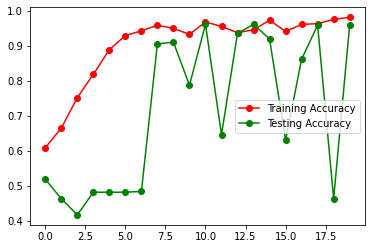

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

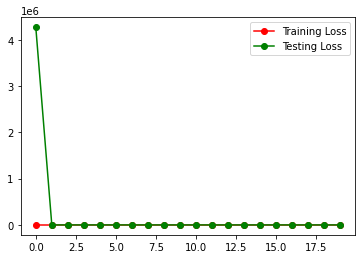

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/
val_generator = ImageDataGenerator(rescale=1./255.)
val_datagen = val_generator.flow_from_directory(
    test_folder, 
    batch_size=round(len(df_test)/2), # 14/2 = 7
    target_size=(224, 224),
    shuffle=False
)
# for i in range(5):
#     img, label = pic.next()
#     ax[i].imshow(img[0])
#     ax[i].set_xlabel('Caries' if np.argmax(label) == 0 else 'No-Caries',fontsize=12)

Found 432 images belonging to 2 classes.


In [ ]:
Y_true = val_datagen.classes
Y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
Y_pred  = modelResNet50v2.predict(val_datagen).round()
Y_pred[0:5]

2/2 [==============================] - 2s 656ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
Y_true_onehot = tf.keras.utils.to_categorical(Y_true)
Y_true_onehot[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
target_names = ['caries','no-caries']
print(classification_report(Y_true_onehot , Y_pred, target_names = target_names))

              precision    recall  f1-score   support

      caries       1.00      0.92      0.96       224
   no-caries       0.92      1.00      0.96       208

   micro avg       0.96      0.96      0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432
 samples avg       0.96      0.96      0.96       432



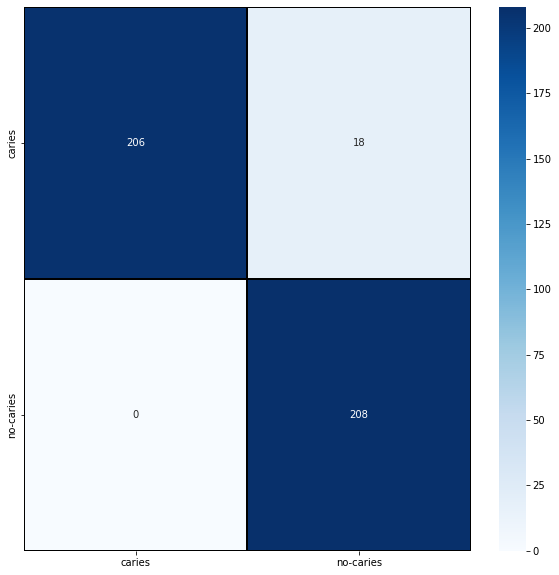

In [ ]:
cm = confusion_matrix(Y_true_onehot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = ['caries','no-caries'] , columns = ['caries','no-caries'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve, auc
print("roc_auc_score:",roc_auc_score(Y_true_onehot,Y_pred))

roc_auc_score: 0.9598214285714286


In [ ]:
precision_score(Y_true_onehot,Y_pred,average=None)

array([1.        , 0.92035398])

In [ ]:
recall_score(Y_true_onehot,Y_pred,average=None)

array([0.91964286, 1.        ])

In [ ]:
f1_score(Y_true_onehot,Y_pred,average=None)

array([0.95813953, 0.95852535])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_onehot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

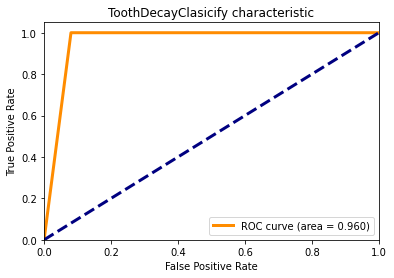

In [ ]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ToothDecayClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

<ipython-input-298-c643d80d3064>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


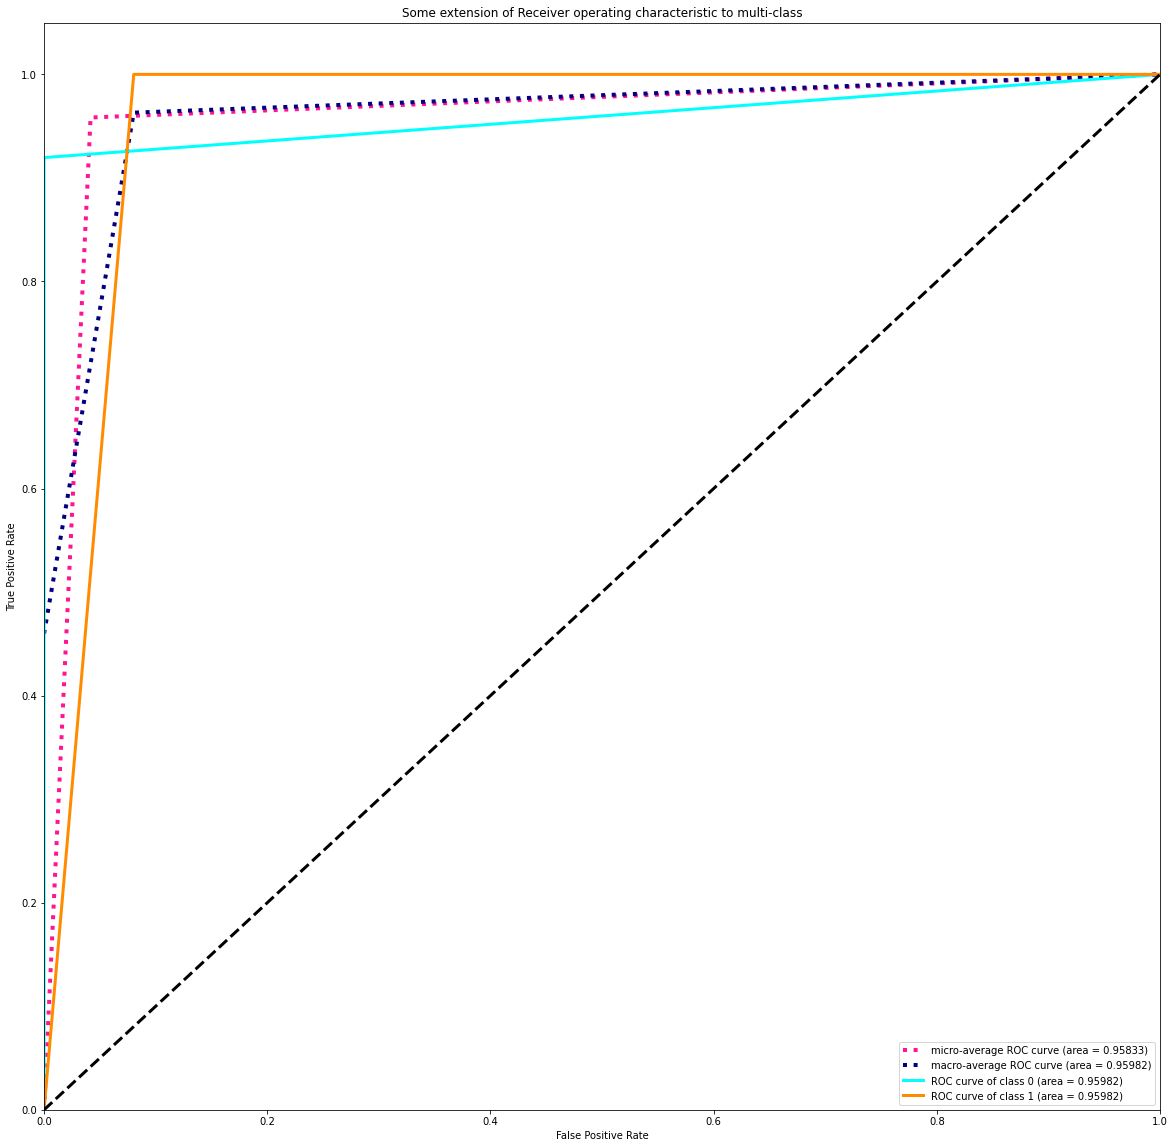

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Fast api

In [ ]:
#!zip -r /content/file.zip /content/File_V23/

In [ ]:
classes = ['carries','no-caries']

In [ ]:
pip install fastapi

In [ ]:

# Define a function to decode the prediction
def decode_prediction(p):
  print(p)
  if p[0] > p[1]:
    return 'Caries'
  else:
    return 'no-Caries'

In [ ]:

# Define a Preproccecing
def preprocessing(image):
  
    # Resize the image to match the model's input size
    image = cv2.resize(image, (224, 224))

    # Convert the image to a NumPy array and scale the pixel values
    image_array = image.astype(np.float32) / 255.0
    return image_array


#  The Best Model is ResNet50v2 "loss: 0.075 - accuracy: 0.981 Validate Loss:0.202 Validate Accuracy 0.958" : 
 


#Export The Best Model To use As Api  

In [ ]:

# Save the model
#tf.saved_model.save(modelResNet50v2, "drive/MyDrive/VGG16V2")


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')